# Project 2: Numerical Methods
This project aims to identify the most accurate numerical integration method for a damped mass-spring system.

Created by j01124rd

Date: 5 of April 2024

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
from scipy.integrate import solve_ivp

plt.rcParams.update({'font.size': 16})
plt.style.use('default')

### Damped Mass-Spring System

A damped mass-spring system consists of a mass attached to a spring and a damper. The system's dynamics are governed by a second-order differential equation that accounts for the spring's restoring force, the damper's resistance (which opposes velocity), and any external forces applied to the mass. The equation typically takes the form

$$m \ddot{x}+b \dot{x}+kx=F(t)$$

where $m$ is the mass, $b$ is the damping coefficient, $k$ is the spring constant, $x$ is the displacement, and $F(t)$ represents the time-dependent external force.

#### Applied Force Variants
##### Sudden Force: 
A sudden (or impulse) force is applied instantaneously to the system, often modeled as a Dirac delta function. This force abruptly changes the system's velocity at a specific moment in time, providing a sharp input to study the system's transient response.

#####  Sinusoidal Force: 
A sinusoidal force varies cyclically over time, modeled as 
$$F(t) = F_0 \sin{\omega t + \phi}$$

where, $F_0$ is the amplitude, $\omega$ is the angular frequency, and $\phi$ is the phase. This type of force is used to examine the system's steady-state oscillatory response and to study phenomena such as resonance, where the system's natural frequency aligns with the frequency of the external force, often leading to significant increases in amplitude.

### Constants and Initial Conditions

In this sysem we will use following constant values. Additionally we use the range of values of low damping coefficients, time step size and total time taken for broader view of the system and more accurate analysis.

In [21]:
# Physics parameters
m = 5.58  # mass in kg
k = 1.81  # spring constant in kg/s^2

# Initial conditions
x0 = 0  # initial position in m
v0 = -1.0  # initial velocity in m/s

# Damping coefficient, Total Time, Time steps h
b = [0.1, 0.5, 2.0]  # damping coefficient in kg/s
T = [50.0, 150.0, 300]  # Total time
h = [0.1, 0.05, 0.01]  # Time step sizes in sec

### Analytical Solutions:
Analytical solutions provides guidance of what we should expect from the system. It allows us to compare different numerical methods of integration in order to determine best method.
#### Low Damping:
The solution that applies to the underdamped systems is given as 
$$ x(t) =e^{\frac{-bt}{2m}}\left(Ae^{i\omega_d t}+ Be^{-i\omega_d t}\right) $$

where 

$$\omega_d = \sqrt{\frac{(4km-b^2)}{2m}}$$

$$A=\left(\frac{b}{2i\sqrt{4km-b^2}}+\frac{1}{2}\right)x_0 +\frac{y_0 m}{\sqrt{4km-b^2}i}$$
$$B = x_0-A$$
#### Critical Damping:
The solution that applies to the critically damped systems is given as 
$$ x(t) = (A+Bt)e^{\frac{-bt}{2m}}$$

where 

$$A= x_0$$
$$B= v_0 + \frac{b}{2m}x_0$$
#### Heavy Damping:
The solution that applies to the heavily damped systems is given as
$$x(t) = Ae^{\lambda_1 t}+Be^{\lambda_2 t}$$

where

$$\lambda_1 = \frac{-b}{2m}+r$$
$$\lambda_2 = \frac{-b}{2m}-r$$
$$r = \sqrt{\frac{b^2}{4m^2}-\frac{k}{m}}$$
$$A = x_0 -B$$
$$B = \frac{v_0 - \lambda_1 x_0}{\lambda_2- \lambda_1}$$

In [22]:
# The analytic solution when b is less than b_cr
def Analytic(x0, v0, time, b):
    """
    Analytical solution for underdamped mass-spring system.
    """
    # Constants
    A = (b/(2*1j*cmath.sqrt(4*k*m-b**2))+1/2)*x0+v0*m/(cmath.sqrt(4*k*m-b**2)*1j) 
    B = x0-A
    
    X = np.exp(-b*time/(2*m))*(A*np.exp(1j*cmath.sqrt(4*k*m-b**2)*time/(2*m))
                              +B*np.exp(-1j*cmath.sqrt(4*k*m-b**2)*time/(2*m)))

    return X

def AnalyticCritical(x0, v0, time, b):
    """
    Analytical solution for a critically damped mass-spring system.
    """
    # Calculate A and B based on initial conditions
    A = x0
    B = v0 + (b * x0) / (2 * m)
    
    # Solution for critical damping
    X = (A + B * time) * np.exp(-b * time / (2 * m))
    return X

def AnalyticOverdamped(x0, v0, time, b):
    """
    Analytical solution for an overdamped mass-spring system.
    """
    # Calculate roots of characteristic equation
    omega0 = np.sqrt(k / m)
    r = np.sqrt(b**2 - 4 * k * m) / (2 * m)
    
    lambda_1 = -b / (2 * m) + r
    lambda_2 = -b / (2 * m) - r
    
    # Calculate A and B based on initial conditions
    # Using the system of equations: x0 = A + B, v0 = lambda_1*A + lambda_2*B
    B = (v0 - lambda_1 * x0) / (lambda_2 - lambda_1)
    A = x0 - B
    
    # Solution for overdamping
    X = A * np.exp(lambda_1 * time) + B * np.exp(lambda_2 * time)
    return X

### Functions - Numerical Methods of Integration

This experiment investigates 5 different method of numerical integration: Euler's, Improved Euler's, Verlet's, Euler-Cromer's, and Runge-Kutta of order 4. Last one is defined by using built in algorithm in the scipy integration library showing alternative (easier to implement) method. 

#### Euler Method:
This method can be used in the following way,

$$a_{i} = -(k/m) x_{i} -(b/m) v_{i}$$
$$x_{i+1} = x_{i} + h \cdot v_{i}$$ 
$$v_{i+1} = v_{i} + h \cdot a_{i}$$ 

with the error $\sim 0(h)$.

#### Improved Euler Method:
This method is just slight adjustment to the previous method by adding additional term from the Taylor expansion that will increase the accuracy

$$a_{i} = -(k/m) x_{i} -(b/m) v_{i}$$
$$x_{i+1} = x_{i} + h \cdot v_{i} + \frac{h^2}{2}a_i$$ 
$$v_{i+1} = v_{i} + h \cdot a_{i}$$ 

with the error $\sim 0(h^3)$.

#### Verlet's Method:
The Verlet's method uses centred derivative. We must expand using Taylor expansion $x(t+h)$ and $x(t-h)$ up to the 4th term and then we add them and also subtract to obtain expressions for $x^{'}(t)$ and $x^{''}(t)$. After all of the above calculation we can implement it as follows

$$a_{i} = -(k/m) x_{i} -(b/m) v_{i}$$
$$x_{i+1} = 2x_{i} + x_{i-1} + h^2a_i$$ 
$$v_{i} = \frac{x_{i+1}-x_{i-1}}{2h}$$

with the error $\sim 0(h^2)$. It requires to use Euler method or similar for the first step.

#### Euler-Cromer's Method:
It is another adjusted Euler's Method which is a type of Symplectic Integrator, i.e. it is energy-preserving. This method conserves the energy but there are oscillations about the average, compared to true value of energy. It can be written as

$$x_{i+1} = x_{i} + h \cdot v_{i+1}$$ 
$$v_{i+1} = v_{i} + \frac{hk}{m} \cdot x_{i}$$ 

#### Runge-Kutta's 45 Method:
The Runge-Kutta 4th order method (RK4) is used to numerically solve the dynamics of a damped mass-spring system, modeled by second-order differential equations, by converting them into a set of first-order differential equations. The RK4 method calculates intermediate slopes ($k$ values) to approximate the solution over a single timestep:

This is governs by the following method
$$k_1 = hf(t_i, y)$$
$$k_2 = hf(t_i+h/2, y_i +k_1/2)$$
$$k_3 = hf(t_i+h/2, y_i+k_2/2)$$
$$k_4 = hf(t_i+h,y_i+k_3)$$

The solution is then updated using:

$$y_{i+1}=y_i+\frac{1}{6}(k_1+2k_2+2k_3+k_4)$$

Here, $f(t_i, y)$ represents the system's rate of change at time $t$, incorporating both spring force and damping force. The step size is denoted by $h$, and the weighted average of the $k$ values provides a fourth-order accurate approximation of the system's state at the next timestep. This method offers a precise balance between computational efficiency and accuracy, making it highly suitable for simulating physical systems like the damped mass-spring system.

In [23]:
# The method implementation of Euler's Method
def EulerMethod(x0, v0, nsteps, hstep, b):
    """
    Numerical Method: Euler's
    """
    # Create empty arrays ready for the values of x and v
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    energy = np.zeros(nsteps)

    # Assign initial conditions
    x[0] = x0 
    v[0] = v0
    energy[0] = 0.5 * m * v0**2 + 0.5 * k * x0**2

    for i in range(nsteps-1):

        # Calculate the acceleration at step i (in m/s)
        a = -(k/m)*x[i] - (b/m)*v[i]
        # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
        x[i+1] = x[i] + v[i]*hstep
        v[i+1] = v[i] + a*hstep
        # Calculate energy at each step
        energy[i+1] = 0.5 * m * v[i+1]**2 + 0.5 * k * x[i+1]**2
        
    return x, v, energy

# The method implementation of Improved Euler's Method
def ImprovedEuler(x0, v0, nsteps, hstep, b):
    """
    Numerical Method: Improved Euler's
    """
    # Create empty arrays ready for the values of x and v
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    energy = np.zeros(nsteps)

    # Assign initial conditions
    x[0] = x0 
    v[0] = v0
    energy[0] = 0.5 * m * v0**2 + 0.5 * k * x0**2
    
    for i in range(nsteps-1):
        # Calculate the acceleration at step i (in m/s^2)
        a = -(k/m)*x[i] - (b/m)*v[i]
        # Improved Euler method adjustment
        x[i+1] = x[i] + v[i]*hstep + (hstep**2 / 2) * a
        v[i+1] = v[i] + a*hstep
        # Calculate energy at each step
        energy[i+1] = 0.5 * m * v[i+1]**2 + 0.5 * k * x[i+1]**2
        
    return x, v, energy

def VerletMethod(x0, v0, nsteps, hstep, b):
    """
    Numerical Method: Verlet's
    """
    # Initialize arrays for positions, velocities, and accelerations
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    energy = np.zeros(nsteps)

    # Set initial conditions
    x[0], v[0] = x0, v0
    energy[0] = 0.5 * m * v0**2 + 0.5 * k * x0**2

    # First step using Euler's method to estimate x[1] and v[1]
    if nsteps > 1:
        x[1] = x0 + hstep * v0 + 0.5 * ((-(k/m) * x0 - (b/m) * v0) * hstep**2)
        # Recalculate acceleration at x[1] for consistency
        v[1] = v0 + ((-(k/m) * x[1] - (b/m) * v0) * hstep)
        energy[1] = 0.5 * m * v[1]**2 + 0.5 * k * x[1]**2

    # Main Verlet integration loop for damped systems
    for i in range(1, nsteps - 1):
        x[i+1] = 2*x[i] - x[i-1] + hstep**2 * (-(k/m) * x[i] - (b/m) * v[i])
        # Update velocity using central difference
        v[i+1] = (x[i+1] - x[i-1]) / (2*hstep)
        # Recalculate acceleration at the new position and velocity
        energy[i+1] = 0.5 * m * v[i+1]**2 + 0.5 * k * x[i+1]**2

    return x, v, energy

# The method implementation of Euler-Cromer's Method
def EulerCromerMethod(x0, v0, nsteps, hstep, b):
    """
    Numerical Method: Euler-Cromer's
    """
    # Create empty arrays ready for the values of x and v
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    energy = np.zeros(nsteps)
    
    # Assign initial conditions
    x[0] = x0
    v[0] = v0
    energy[0] = 0.5 * m * v0**2 + 0.5 * k * x0**2
    
    for i in range(1, nsteps):
        # Calculate the acceleration at step i-1
        a = -(b/m) * v[i-1] - (k/m) * x[i-1]
        # Update velocity at step i using the acceleration at step i-1
        v[i] = v[i-1] + hstep * a
        # Update position at step i using the updated velocity at step i
        x[i] = x[i-1] + hstep * v[i]
        # Calculate energy at each step
        energy[i] = 0.5 * m * v[i]**2 + 0.5 * k * x[i]**2
    
    return x, v, energy

# The additional Runge-Kutta method using scipy integration
def RungeKutta(x0, v0, nsteps, hstep, b):
    """
    Numerical Method: Runge-Kutta's
    """
    # Defines the start and end times based on nsteps and hstep
    t_span = [0, nsteps * hstep]
    # Time points at which to solve
    t_eval = np.linspace(t_span[0], t_span[1], nsteps)  
    
    # Define the ODE system
    def mass_spring_damper_system(t, y):
        x, v = y
        dxdt = v
        dvdt = -(b/m) * v - (k/m) * x
        return [dxdt, dvdt]
    
    # Initial conditions
    y0 = [x0, v0]
    
    # Solve the ODE
    sol = solve_ivp(mass_spring_damper_system, t_span, y0, method='RK45', t_eval=t_eval)
    
    # Calculate energy
    energy = 0.5 * m * sol.y[1]**2 + 0.5 * k * sol.y[0]**2
    
    return sol.t, sol.y[0], sol.y[1], energy  # Returning time, x (displacement), and v (velocity)


### Investigation of all methods for two different scenarios

##### Scenario 1: Constant step size and varying damping coefficient.

The time step have been chosen the smallest one $h=0.01$ s, so that we can see the effect of varying damping when methods are most efficient. The damping coeffcients are chosen to be $0.1, 0.5, 1.0$ kg/s. Code iterates through all coeffcients for every method and plot the obtained results.

##### Scenario 2: Constant damping coefficient and varying step size.

In this part we will more closely investigate what happens to chosen methods when the time step size is decreasing from $0.1$ s down to $0.05$ s and then $0.01$ s. For this part we assumed damping constant to be $b=0.1$ kg/s. It is chosen to be small so that we can observe effects of different step size for a longer period of time. Results are plotted for visual comparison of each method.

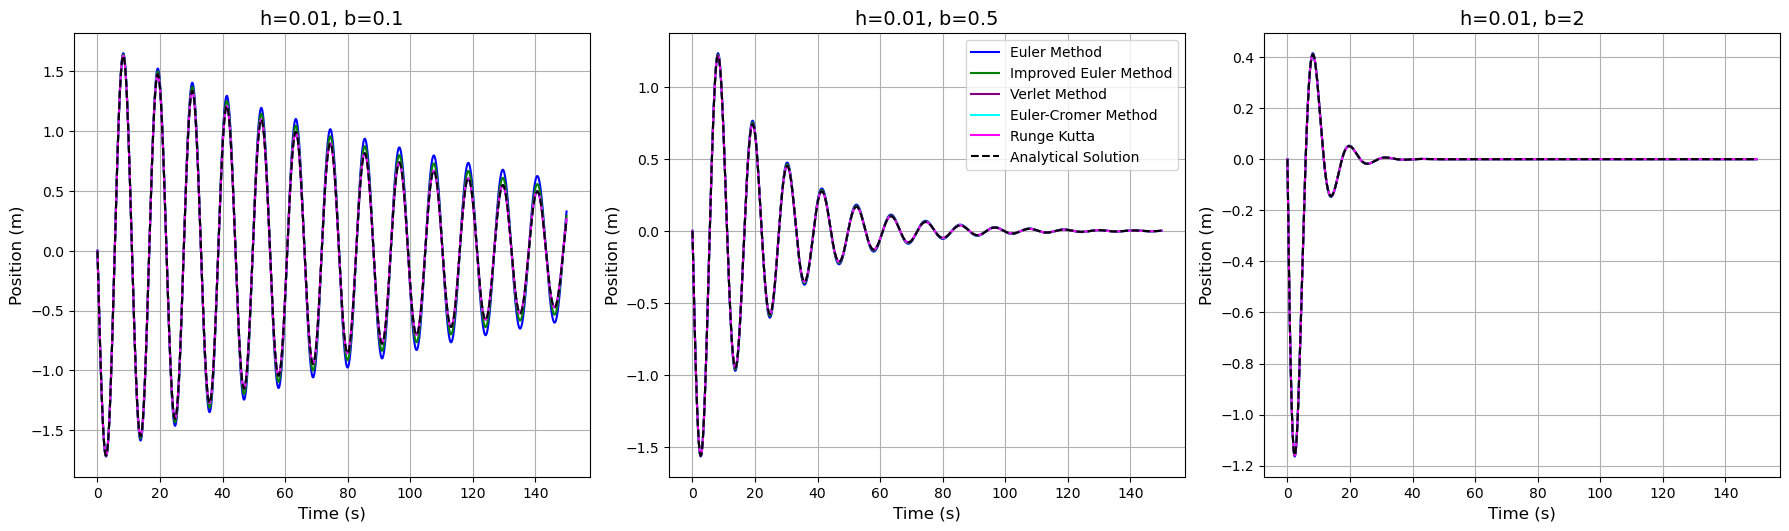

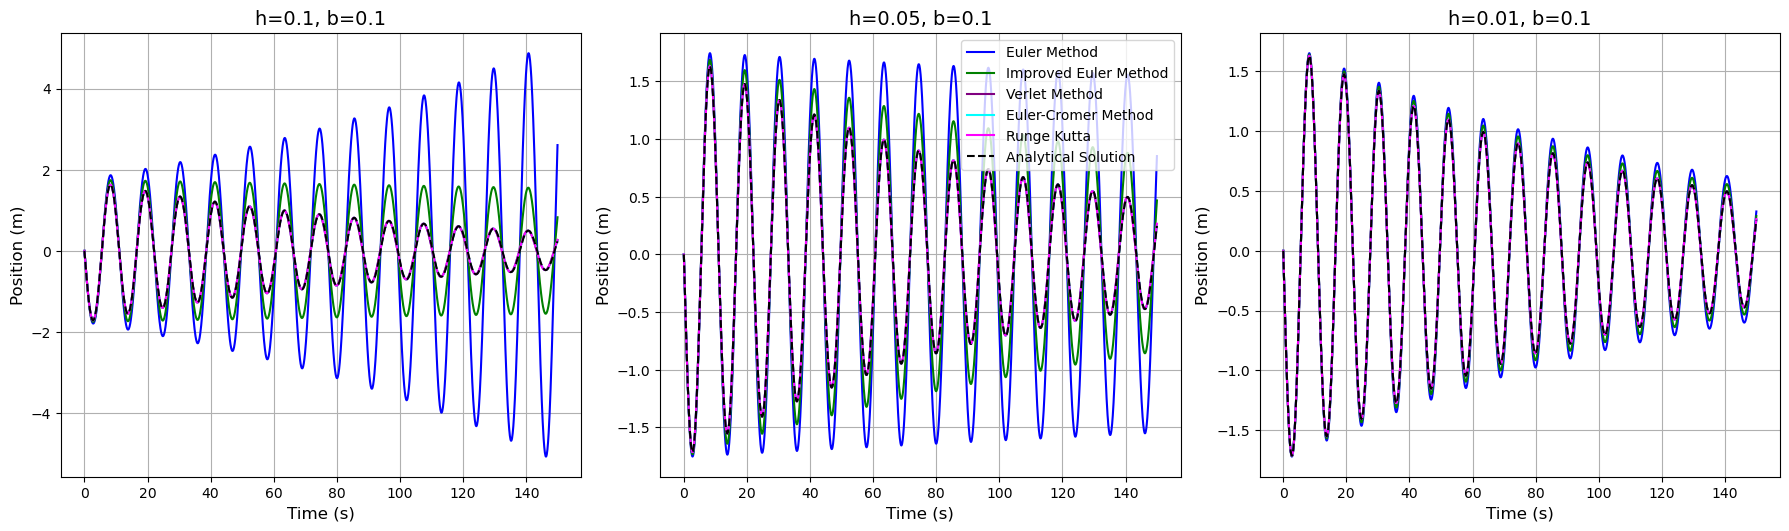

In [24]:
def run_simulation(hstep, b, T):
    """
    This function runs all numerical methods.
    """
    # Defining number of stes and time range
    nsteps = int(np.ceil(T / hstep))
    t_range = np.arange(0, T, hstep)
    
    # Run existing numerical methods
    x_euler, v_euler, energy_euler = EulerMethod(x0, v0, nsteps, hstep, b)
    x_improved, v_improved, energy_improved = ImprovedEuler(x0, v0, nsteps, hstep, b)
    x_verlet, v_verlet, energy_verlet = VerletMethod(x0, v0, nsteps, hstep, b)
    x_euler_cromer, v_euler_cromer, energy_euler_cromer = EulerCromerMethod(x0, v0, nsteps, hstep, b)
    x_analytic = Analytic(x0, v0, t_range, b).real
    t_rk, x_rk, v_rk, energy_rk = RungeKutta(x0, v0, nsteps, hstep, b)
    
    return t_range, x_euler, x_improved, x_verlet, x_euler_cromer, x_analytic, x_rk

def plot_simulation_for_constant_h_varying_b(index, t_range, x_euler, x_improved, x_verlet, 
                                             x_euler_cromer, x_analytic, x_rk, b_val, hstep, T):
    """
    Plotting simulation for step size being held 
    constant and damping coefficient being varied.
    """
    # Adjust subplotting based on the total number of plots to display.
    plt.subplot(2, 3, index + 1)
    # Plots
    plt.plot(t_range, x_euler, label='Euler Method', linestyle='-', color='blue')
    plt.plot(t_range, x_improved, label='Improved Euler Method', linestyle='-', color='green')
    plt.plot(t_range, x_verlet, label='Verlet Method', linestyle='-', color='purple')
    plt.plot(t_range, x_euler_cromer, label='Euler-Cromer Method', linestyle='-', color='cyan')
    plt.plot(t_range, x_rk, label='Runge Kutta', linestyle='-', color='magenta')
    plt.plot(t_range, x_analytic, label='Analytical Solution', linestyle='--', color='black')
    # Title and lables
    plt.title(f'h={hstep}, b={b_val:.3g}', fontsize=14)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Position (m)', fontsize=12)
    # Legend that can be adjusted to be present on one of the figures (you can select which one)
    if index % 3 == 1: 
        plt.legend()
    plt.grid(True)

# Create the figure before calling plot_simulation for a group of subplots
plt.figure(figsize=(18, 10))
# Iteration through damping coefficient to plot all possible combinations for constant h
for index, b_val in enumerate(b):
    results = run_simulation(h[2], b_val, T[1])
    plot_simulation_for_constant_h_varying_b(index, *results, b_val, h[2], T[1])
plt.tight_layout()
plt.show()

def plot_simulation_for_constant_b_and_varying_h(b_constant, h_values, T):
    """
    Plotting simulation for damping coefficient being held 
    constant and step size being varied.
    """
    # Adjust size of the figure
    plt.figure(figsize=(18, 10))
    
    # Iteration through time steps to plot all possible combinations for constant b
    for index, hstep in enumerate(h_values):
        results = run_simulation(hstep, b_constant, T)
        t_range, x_euler, x_improved, x_verlet, x_euler_cromer, x_analytic, x_rk = results
        plot_simulation_for_constant_h_varying_b(index, t_range, x_euler, x_improved, x_verlet, x_euler_cromer, x_analytic, x_rk, b_constant, hstep, T)
    plt.tight_layout()
    plt.show()

# Call the function to plot all graphs
plot_simulation_for_constant_b_and_varying_h(b[0], h, T[1])

### Observation Notes 1

##### Scenario 1:
The differences are very small. We can see that for smallest damping coefficient $b=0.1$ kg/s, the Euler's Method is deviating the most from the analytical curve. As the damping increases almost all methods appears to be matching analytical curve very closely and there is no significant distinction between them.

##### Scenario 2:
We can observe that Euler's method appears to be the worst method of all. For largest time step $h=0.1$ s it increases that disagrees with conservation of energy (similarly to Improved Euler, however it is less extreme effect), therefore it doesn't make physical sense. Runge_Kutta's, Verlet's, and Euler-Cromer's methods seem to be consistent regardless of the step size and reproduce analytical method very closely, being almost identical. This will be investigated further in next parts of this notebook.

### Further investigation of methods accuracy using difference between numerical integration method and analytical solution

To clearly show the differences between various numerical methods, an analysis can be conducted by looking at how much each method's results differ from the analytical solution. Ideally, this difference would be zero for every point along the curve, indicating a perfect match between the numerical and analytical solutions. Therefore, any significant deviation from zero on the y-axis would suggest inaccuracies in the numerical approximation. This investigation will be divided into two main parts: the first will examine the impact of changing step sizes while keeping a constant, low damping coefficient; the second will look at the effects of varying damping coefficients around critical values, with a constant step size. This approach will help identify the most effective method under specific system characteristics and highlight the strengths and weaknesses of each method.

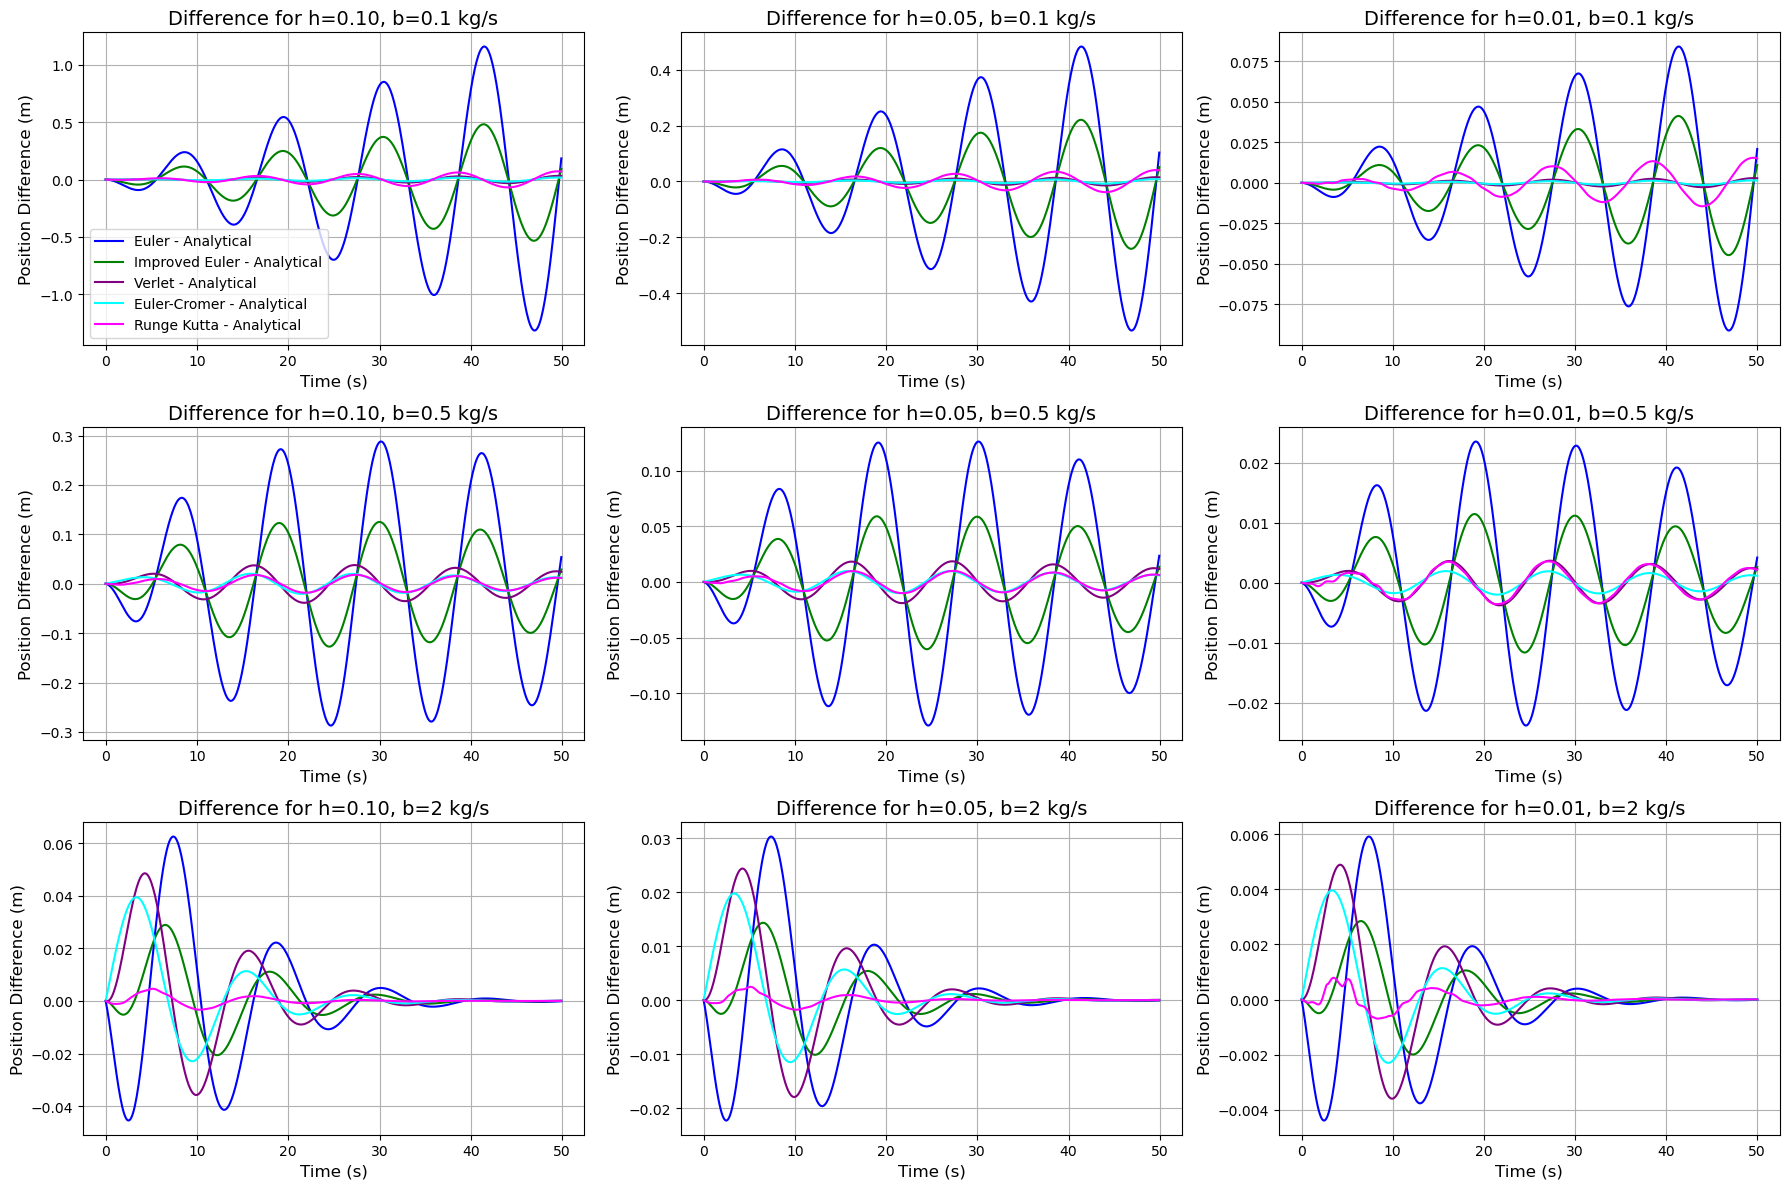

In [25]:
def plot_differences_combined(b_values, h_values, T, subplot_rows, subplot_cols):
    """
    Plotting the difference between the numerical method 
    and the analytical solution. It visually shows how much 
    each method differs from the expected values.
    """
    plt.figure(figsize=(18, 12))  # Adjust figure size to accommodate all subplots

    plot_number = 1
    # Iteration through all damping coeffcient then through all time steps
    for b_val in b_values:
        for hstep in h_values:
            results = run_simulation(hstep, b_val, T)
            t_range, x_euler, x_improved, x_verlet, x_euler_cromer, x_analytic, x_rk = results
            
            # Calculate differences from the analytical solution
            diff_euler = x_euler - x_analytic
            diff_improved = x_improved - x_analytic
            diff_verlet = x_verlet - x_analytic
            diff_euler_cromer = x_euler_cromer - x_analytic
            diff_rk = x_rk - x_analytic  # Difference for Runge-Kutta method
            
            # Plotting with three plots in a row
            plt.subplot(subplot_rows, subplot_cols, plot_number)
            plt.plot(t_range, diff_euler, label='Euler - Analytical', linestyle='-', color='blue')
            plt.plot(t_range, diff_improved, label='Improved Euler - Analytical', linestyle='-', color='green')
            plt.plot(t_range, diff_verlet, label='Verlet - Analytical', linestyle='-', color='purple')
            plt.plot(t_range, diff_euler_cromer, label='Euler-Cromer - Analytical', linestyle='-', color='cyan')
            plt.plot(t_range, diff_rk, label='Runge Kutta - Analytical', linestyle='-', color='magenta')  # Plotting the difference for RK
            
            # Title and labels
            plt.title(f'Difference for h={hstep:.2f}, b={b_val:.3g} kg/s', fontsize=14)
            plt.xlabel('Time (s)', fontsize=12)
            plt.ylabel('Position Difference (m)', fontsize=12)
            if plot_number == 1:  # Add legend to the first subplot for clarity
                plt.legend()
            plt.grid(True)
            plt.tight_layout()

            plot_number += 1

    plt.show()

# Call function to show all graphs
plot_differences_combined(b, h, T[0], len(b), len(h))

### Observation Notes 2

The Runge-Kutta method is most accurate in most of the graphs, regardless of the step size, deviate from zero the least, meaning the Runge-Kutta reproduces analytical solution well. The Euler-Cromer  and Verlet methods also performs very well, however the differences are slightly larger than in the best method. We've seen before that the Euler and Improved Euler methods don't conserve energy and it is also observable here, it is shown by the increasing amplitude over time ($E \propto A^2$), which disagrees with the physical observables. This issue becomes less significant with smaller step sizes, indicating that these methods can be useful in scenarios where the parameters are kept low.


### Calculations of damping coefficient 

This part of the code calculates critical values of damping coefficients in order to investigate behavior of the numerical methods under these special circumstances.

Critical damping 

$b_{cr} = 2\sqrt{km}$

Half-Critical damping

$b_{cr} = \sqrt{km}$

Double critical damping

$b_{cr} = 4\sqrt{km}$

In [26]:
def calculate_damping_constants(k, m):
    """
    This function calculates damping coefficients in critical scenarios: 
    half critical, critical, and double critical damping.
    """
    b_crit = 2 * math.sqrt(k * m)
    b_double = 4 * math.sqrt(k * m)
    b_half = math.sqrt(k * m)
    return b_crit, b_double, b_half

# Save all damping values as a array
b_crit, b_double, b_half = calculate_damping_constants(k, m)
b_values_critical = [b_half, b_crit, b_double]

# Print statements with damping numerical values calculated for all situations
print(f"Critical Damping Constant: {b_crit:.2f} kg/s")
print(f"Double the Critical Damping: {b_double:.2f} kg/s")
print(f"Half of the Critical Damping: {b_half:.2f} kg/s")

Critical Damping Constant: 6.36 kg/s
Double the Critical Damping: 12.71 kg/s
Half of the Critical Damping: 3.18 kg/s


### Total Energy comparison for lightly damped system
In this part of the code we investigated what happens to the total energy over time and how does it compare to the analytical solution across given time for three values of the damping coefficient. Starting from no damping, to very low damping and then slightly larger damping.


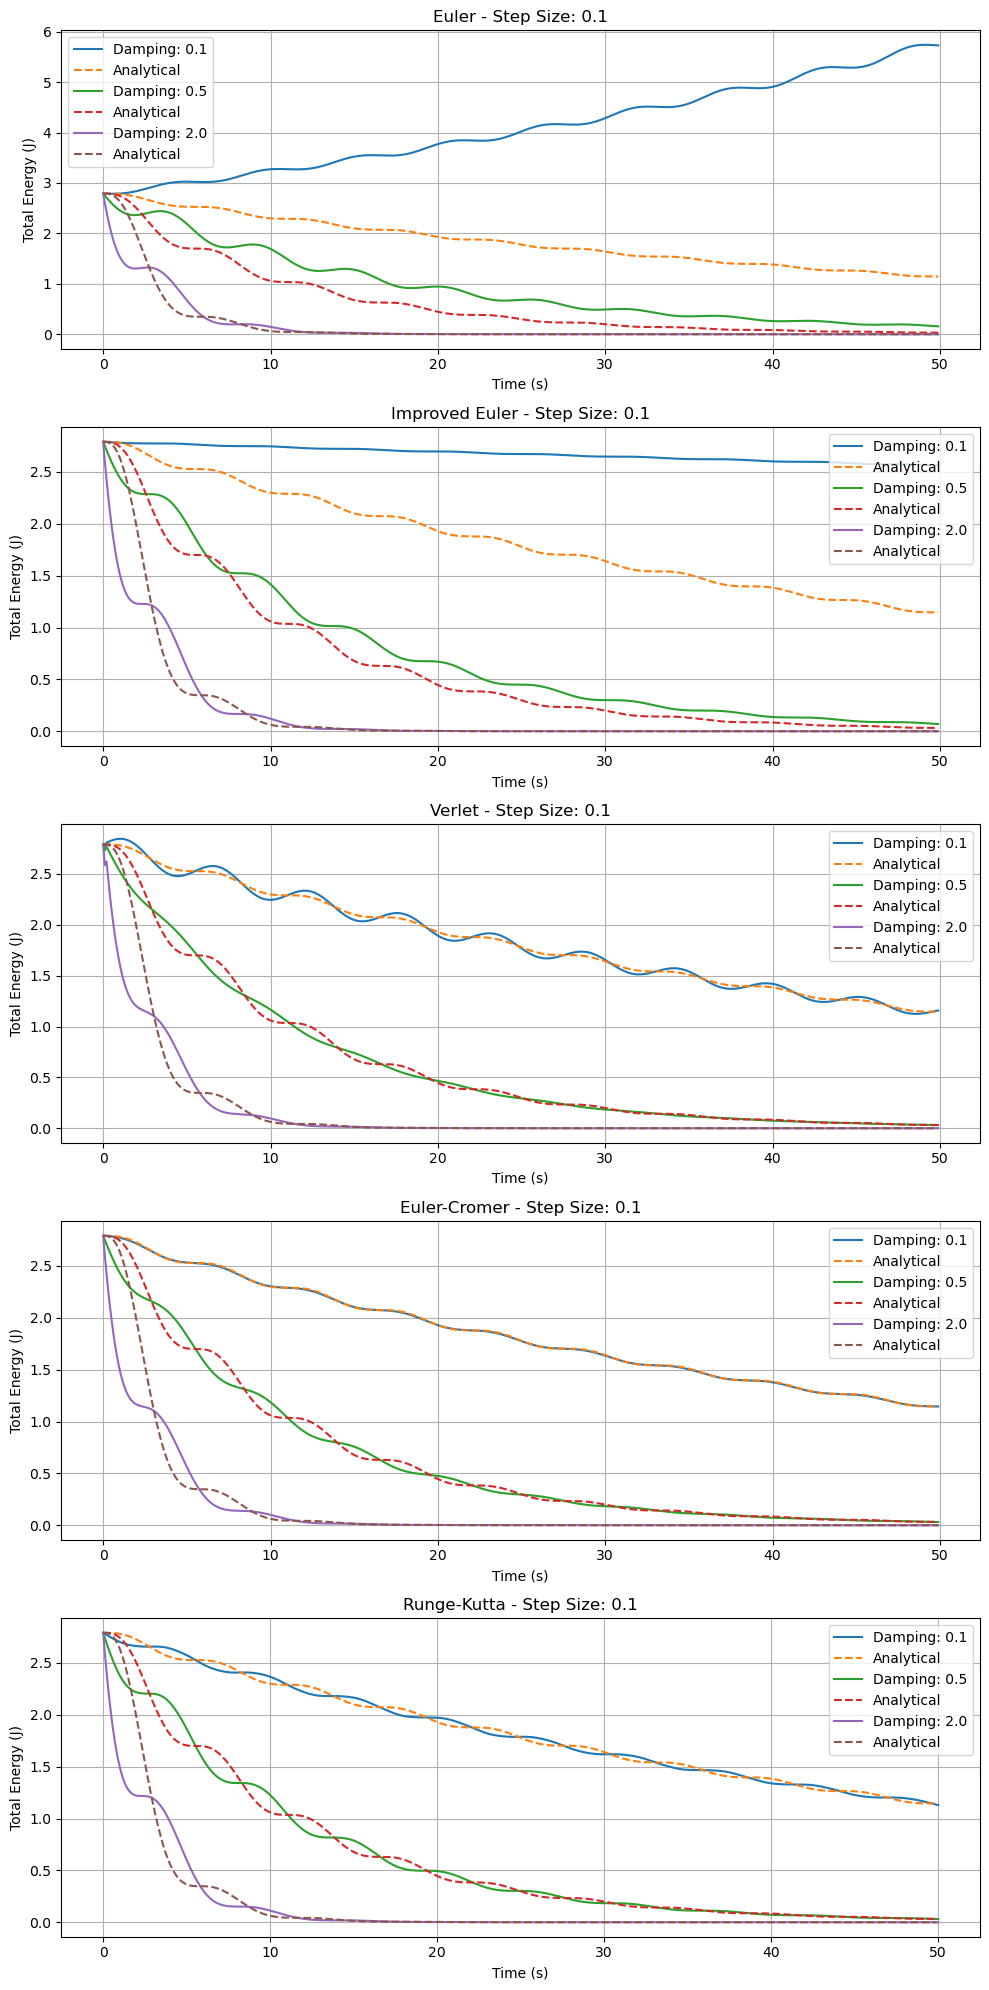

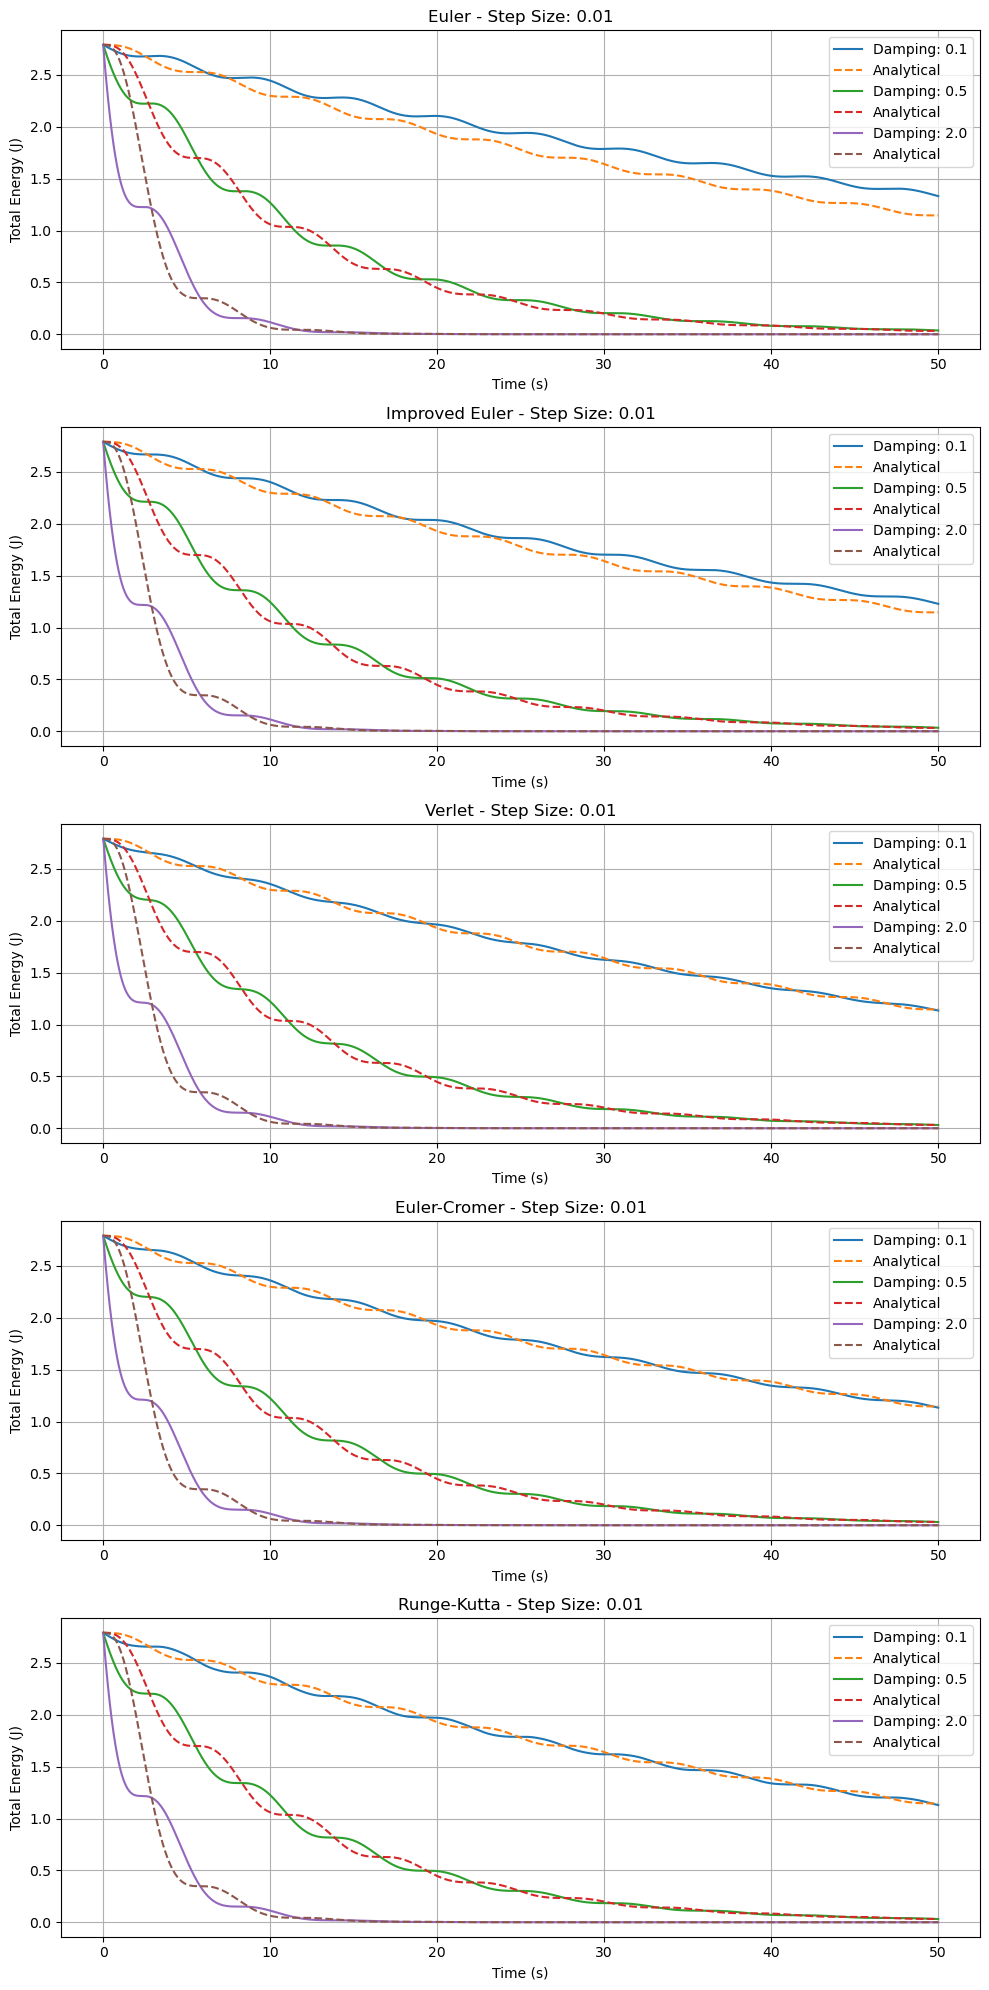

In [27]:
method_names = ['Euler', 'Improved Euler', 'Verlet', 'Euler-Cromer', 'Runge-Kutta']

def total_energy_analytical(x0, v0, time, b):
    """
    This function defines analytical expression for the total energy of the system.
    """
    omega_0 = np.sqrt(k / m)  # Natural frequency
    gamma = b / (2 * m)        # Damping ratio
    omega_d = np.sqrt(omega_0**2 - gamma**2)  # Damped angular frequency
    
    # Coefficients A and B
    A = x0
    B = (v0 + gamma * x0) / omega_d
    
    # Calculate position and velocity as functions of time
    x = A * np.exp(-gamma * time) * np.cos(omega_d * time) + B * np.exp(-gamma * time) * np.sin(omega_d * time)
    v = -gamma * A * np.exp(-gamma * time) * np.cos(omega_d * time) \
        + gamma * B * np.exp(-gamma * time) * np.sin(omega_d * time) \
        - A * omega_d * np.exp(-gamma * time) * np.sin(omega_d * time) \
        + B * omega_d * np.exp(-gamma * time) * np.cos(omega_d * time)
    
    # Calculate potential and kinetic energies
    U = 0.5 * k * x**2
    K = 0.5 * m * v**2
    
    # Total energy
    E = U + K
    return E

def plot_energy_vs_time_per_method(x0, v0, T, h, damping_values):
    """
    This function is plotting the energy versus time for every method.
    """
    # Adjust size of the figure
    plt.figure(figsize=(10, 20))
    
    # Iteration through the methods, creating subplots and labelling
    for i, method_name in enumerate(method_names):
        plt.subplot(len(method_names), 1, i+1)
        plt.title(f'{method_name} - Step Size: {h}')
        plt.xlabel('Time (s)')
        plt.ylabel('Total Energy (J)')

        # Iteration through the dampings
        for damps in damping_values:
            for damp_coeff in damps:
                nsteps = int(T / h)

                # For every method separately
                if method_name == 'Euler':
                    x, v, energy = EulerMethod(x0, v0, nsteps, h, damp_coeff)
                elif method_name == 'Improved Euler':
                    x, v, energy = ImprovedEuler(x0, v0, nsteps, h, damp_coeff)
                elif method_name == 'Verlet':
                    x, v, energy = VerletMethod(x0, v0, nsteps, h, damp_coeff)
                elif method_name == 'Euler-Cromer':
                    x, v, energy = EulerCromerMethod(x0, v0, nsteps, h, damp_coeff)
                elif method_name == 'Runge-Kutta':
                    t, x, v, energy = RungeKutta(x0, v0, nsteps, h, damp_coeff)

                if method_name != 'Runge-Kutta':
                    plt.plot(np.arange(0, T, h), energy, label=f'Damping: {damp_coeff}')
                else:
                    plt.plot(t, energy, label=f'Damping: {damp_coeff}')

                # Plotting analytical solution
                if damp_coeff < b_values_critical[1]:  # Plot analytical solution for underdamped systems
                    analytical_energy = total_energy_analytical(x0, v0, np.arange(0, T, h), damp_coeff)
                    plt.plot(np.arange(0, T, h), analytical_energy, linestyle='--', label='Analytical')

        # Legend and grid
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot
plot_energy_vs_time_per_method(x0, v0, T[0], h[0], [b])
plot_energy_vs_time_per_method(x0, v0, T[0], h[2], [b])

### Observation notes 3


It is evident that both Euler's and Improved Euler's methods struggle to accurately reproduce the analytical solution when the step size is set to $0.1$ seconds, leading to non-conservation of energy as previously mentioned. These methods exhibit improved accuracy with a reduced step size of $0.01$ seconds, but they still deviate more from the analytical solution than the other methods evaluated. In contrast, Verlet's, Euler-Cromer's, and Runge-Kutta's methods adhere more closely to the analytical solution, especially when using a smaller step size. The accuracy of these methods is particularly challenged at a damping rate of $2.0$ kg/s. Given that no definitive best method has emerged from this comparison, further investigation will be conducted on the three most promising methods under critical conditions. Note that we can observe discrepancies between analytical solutions and all methods in form of out of phase oscillations, however the general trend is reproduced.

### Further investigation using critical damping coefficients on two best methods

The process of plotting position against the time has been repeated for three best methods Verlet's, Runge-Kutta and Euler-Cromer with damping coefficients around the critical values: $b_{cr}, \frac{b_{cr}}{2}, 2b_{cr}$. It allows us to analyse behavior of the algorithms in critical conditions, so that we can decide whether Verlet, Runge-Kutta and Euler-Cromer's method behave the best in this scenario. As we could see from the energy plots with sufficiently small step size the difference was small between these three methods and that it requires closer look. 

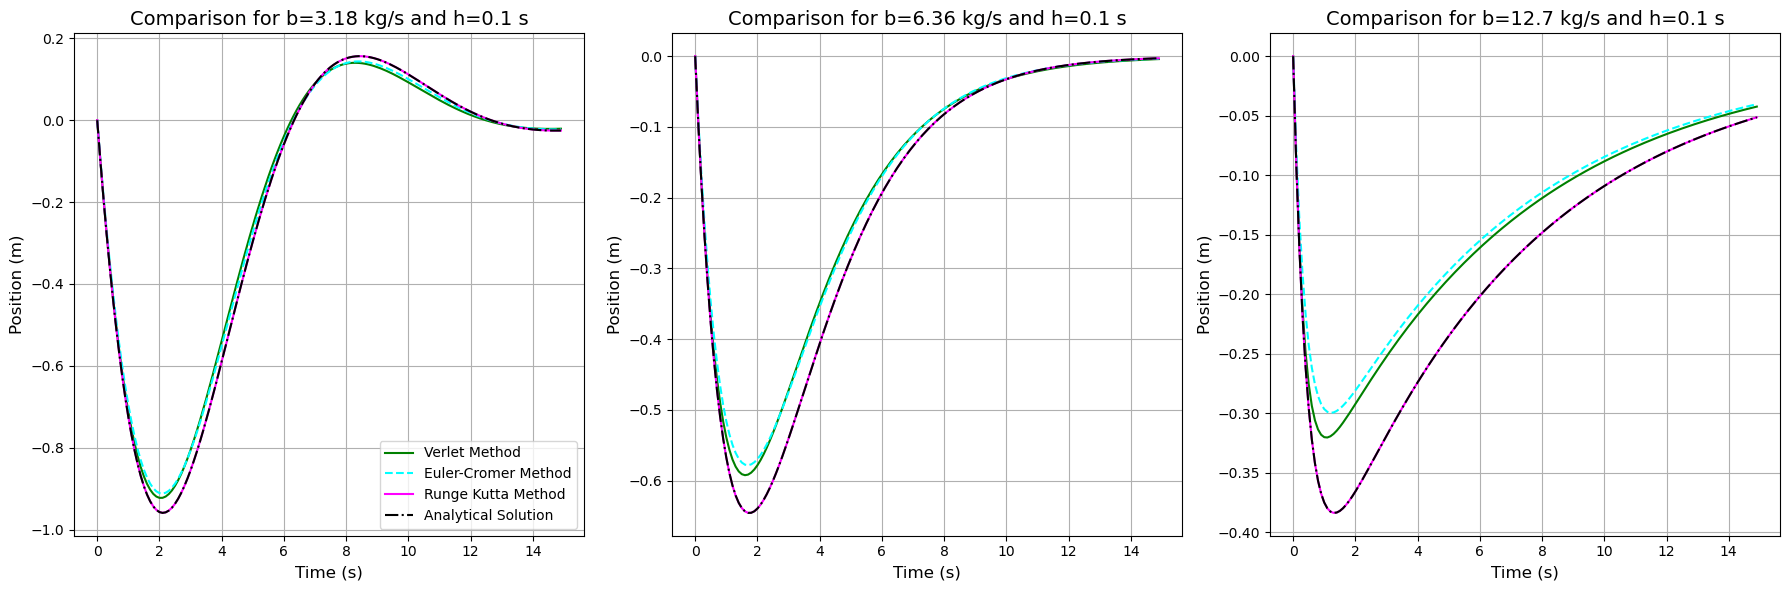

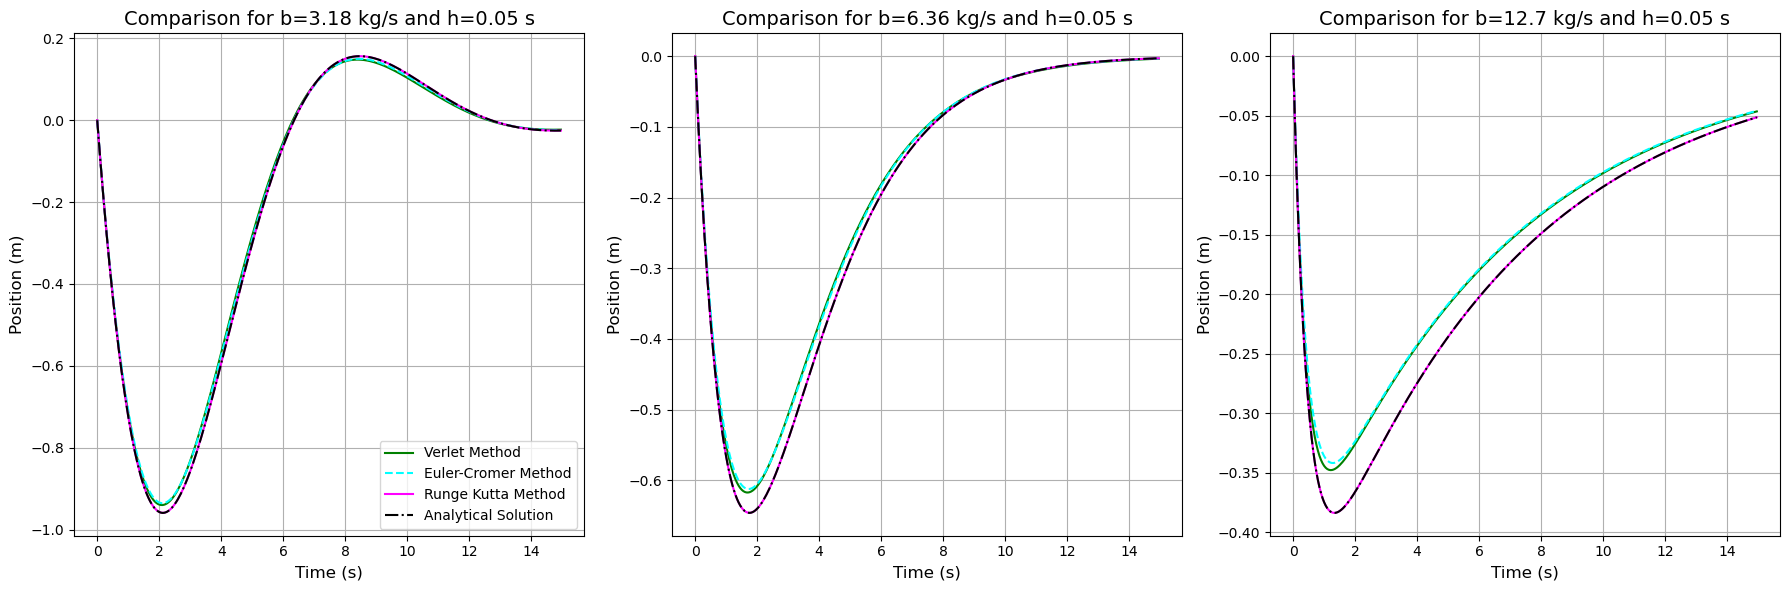

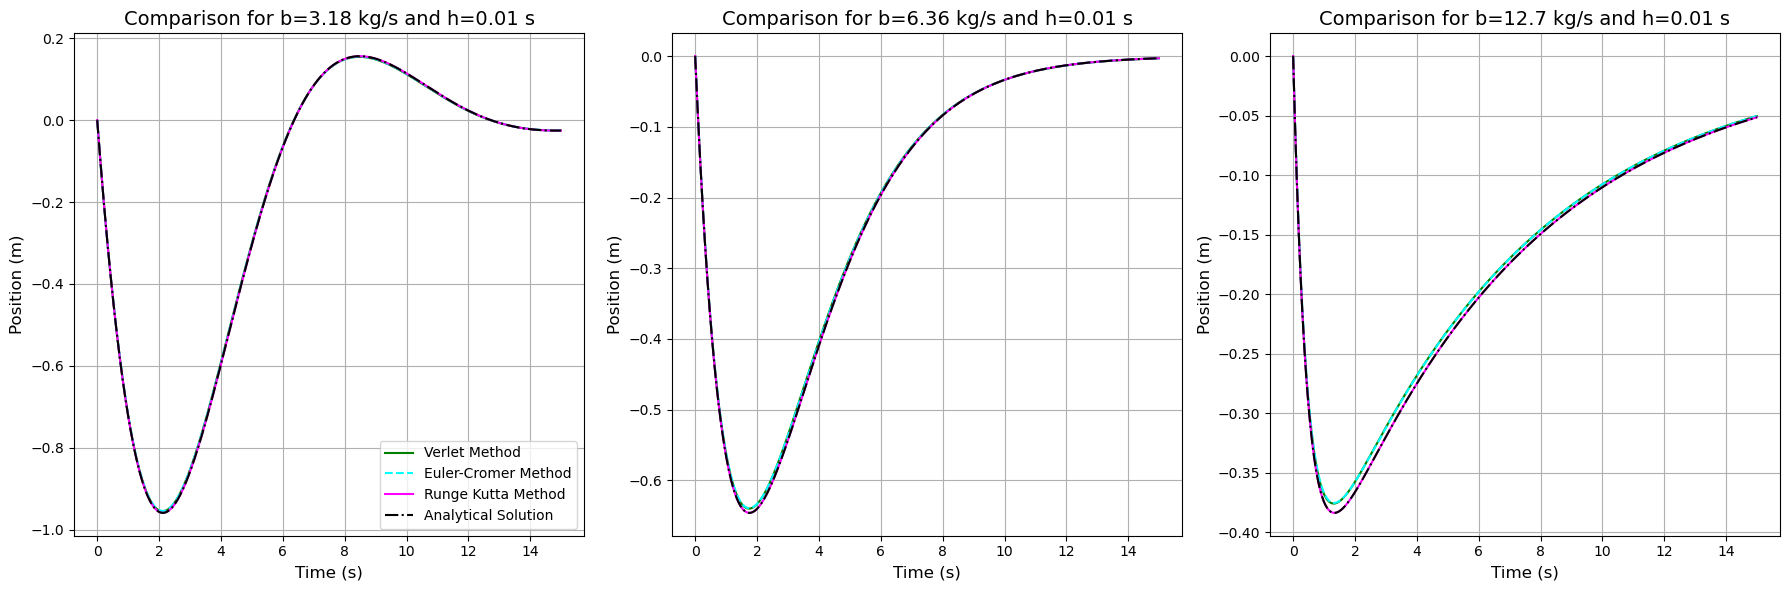

In [28]:
def run_simulation_best(hstep, b, T):
    """
    This function runs three best methods for further investigation.
    """
    # Define number of steps and time range
    nsteps = int(T / hstep)
    t_range = np.arange(0, T, hstep)
    
    # Three best numerical methods
    x_euler_cromer, v_euler_cromer, _ = EulerCromerMethod(x0, v0, nsteps, hstep, b)
    t_rk, x_rk, v_rk, _ = RungeKutta(x0, v0, nsteps, hstep, b)
    x_verlet, v_verlet, _ = VerletMethod(x0, v0, nsteps, hstep, b)
    
    return t_range, x_euler_cromer, x_rk, x_verlet

def plot_simulation_results_with_analytical(b_values, h_values, T):
    """
    This function is plotting three best methods in critical conditions 
    showing analytical curve as a reference.
    """
    # Iteration through all time steps
    for hstep in h_values:
        # Adjusting figure size
        plt.figure(figsize=(18, 6))

        # Calculate reference critical damping value for comparison
        b_cr_ref = 2 * np.sqrt(k * m)
        
        # Iteration through all damping coefficients
        for index, b_val in enumerate(b_values, start=1):
            # Generate time range for plotting
            nsteps = int(T / hstep)
            t_range = np.linspace(0, T, nsteps)
            
            # Determine the damping scenario for analytical solutions
            if b_val < b_cr_ref:  # Underdamped
                analytical_solution = Analytic(x0, v0, t_range, b_val).real
            elif b_val == b_cr_ref:  # Critically damped
                analytical_solution = AnalyticCritical(x0, v0, t_range, b_val)
            else:  # Overdamped
                analytical_solution = AnalyticOverdamped(x0, v0, t_range, b_val)

            # Run simulation for Verlet, Euler-Cromer, and Runge-Kutta methods
            t_range, x_euler_cromer, x_rk, x_verlet = run_simulation_best(hstep, b_val, T)

            # Plotting
            plt.subplot(1, len(b_values), index)
            plt.plot(t_range, x_verlet, label='Verlet Method', linestyle='-', color='green')
            plt.plot(t_range, x_euler_cromer, label='Euler-Cromer Method', linestyle='--', color='cyan')
            plt.plot(t_range, x_rk, label='Runge Kutta Method', linestyle='-', color='magenta')
            plt.plot(t_range, analytical_solution, label='Analytical Solution', linestyle='-.', color='black')
            # Title and labels
            plt.title(f'Comparison for b={b_val:.3g} kg/s and h={hstep:.3g} s', fontsize=14)
            plt.xlabel('Time (s)', fontsize=12)
            plt.ylabel('Position (m)', fontsize=12)
            if index == 1:  # Only add legend to the first subplot to avoid repetition
                plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

# Call for plotting
plot_simulation_results_with_analytical(b_values_critical, h, 15)

### Observations Notes 4

Note, that we shorten total time down to $15$ seconds to present the differences more accurately.

The Verlet and Euler-Cromer Method started to deviate as damping became larger (or step size became larger) and effectively this methods became less accurate than Runge-Kutta.

However, Runge-Kutta method seems to match analytical solutions in every case very closely. Which makes this method best out of three investigated.

### Error calculated using three different methods 

We used following constants:
Damping coefficients: 0.1, 0.5, 2.0 kg/s
Time step size: 0.1 s

We will look at the numerical values of errors determined in three different ways. This code will automatically determine best method (using MAE) assuming that smallest error implies the highest accuracy. The step size was chosen to be the largest among all investigated to see how these functions behave in this situation.

#### Methods used in these calculations:

##### Mean Absolute Error (MAE):

$$MAE = \frac{1}{n}\sum^n_{i=1}|y_{actual}-y_{predicted}|$$

##### Mean Squared Error (MSE):

$$MSE = \frac{1}{n}\sum^n_{i=1}(y_{actual}-y_{predicted})^2$$

##### Root Mean Squared Error (RMSE):

$$RMSE = \sqrt{\frac{1}{n}\sum^n_{i=1}(y_{actual}-y_{predicted})^2}$$

where $n$ is the total number of data points, $y_{actual} - y_{predicted}$ is the difference between the positions in numerical method and analytical solution.

In [29]:
def calculate_errors(y_actual, y_predicted):
    """
    This function calculates the errors using three different methods:
    Mean Absolute Error, Mean Squared Error, and Root Mean Squared Error.
    """
    differences = y_actual - y_predicted
    mae = np.mean(np.abs(differences)) # Mean Absolute Error
    mse = np.mean(np.square(differences)) # Mean Squared Error
    rmse = np.sqrt(mse) # Root Mean Squared Error
    return mae, mse, rmse # in metres

def run_simulation_and_calculate_errors(b, h, T, x0, v0, method_names):
    """
    Computing errors for all methods and determining most accurate one.
    """
    # Run simulation
    t_range, x_euler, x_improved, x_verlet, x_euler_cromer, x_analytic, x_rk = run_simulation(h, b, T)
    # Collect all positions into one array
    solutions = [x_euler, x_improved, x_verlet, x_euler_cromer, x_rk]
    # Empty array for determined errors
    errors = []
    
    # Iteration through all solutions to calculate three methods of error calculations
    for solution, name in zip(solutions, method_names):
        # Calculate errors
        mae, mse, rmse = calculate_errors(x_analytic, solution)
        errors.append((name, mae, mse, rmse))

    # Sort methods by RMSE, MSE, and MAE respectively
    errors_sorted_by_rmse = sorted(errors, key=lambda x: x[3])
    errors_sorted_by_mse = sorted(errors, key=lambda x: x[2])
    errors_sorted_by_mae = sorted(errors, key=lambda x: x[1])

    # Printing errors
    print(f"Simulation Errors for h={h:.3g} s, b={b:.3g} kg/s:")
    print("---------------------------------------------------")
    for error in errors_sorted_by_rmse:
        name, mae, mse, rmse = error
        print(f"{name}:")
        print(f"  - Mean Absolute Error (MAE): {mae:.3g} m")
        print(f"  - Mean Squared Error (MSE): {mse:.3g} m")
        print(f"  - Root Mean Squared Error (RMSE): {rmse:.3g} m")
    print("---------------------------------------------------")

    # Print the best method based on RMSE, MSE, and MAE
    best_method_by_rmse = errors_sorted_by_rmse[0][0]
    best_method_by_mse = errors_sorted_by_mse[0][0]
    best_method_by_mae = errors_sorted_by_mae[0][0]
    print(f"Best Method Based on RMSE: {best_method_by_rmse} (RMSE={errors_sorted_by_rmse[0][3]:.3g}m)")
    print(f"Best Method Based on MSE: {best_method_by_mse} (MSE={errors_sorted_by_mse[0][2]:.3g}m)")
    print(f"Best Method Based on MAE: {best_method_by_mae} (MAE={errors_sorted_by_mae[0][1]:.3g}m)")
    print("---------------------------------------------------\n")

# Method names for proper labelling
method_names = ['Euler Method', 'Improved Euler Method', 'Verlet Method', 'Euler-Cromer Method', 'Runge Kutta Method']

# Call the function
run_simulation_and_calculate_errors(b[0], h[0], T[2], x0, v0, method_names)
run_simulation_and_calculate_errors(b[1], h[0], T[2], x0, v0, method_names)
run_simulation_and_calculate_errors(b[2], h[0], T[2], x0, v0, method_names)
run_simulation_and_calculate_errors(b_values_critical[0], h[0], T[2], x0, v0, method_names)

Simulation Errors for h=0.1 s, b=0.1 kg/s:
---------------------------------------------------
Euler-Cromer Method:
  - Mean Absolute Error (MAE): 0.0116 m
  - Mean Squared Error (MSE): 0.000179 m
  - Root Mean Squared Error (RMSE): 0.0134 m
Runge Kutta Method:
  - Mean Absolute Error (MAE): 0.0124 m
  - Mean Squared Error (MSE): 0.000206 m
  - Root Mean Squared Error (RMSE): 0.0144 m
Verlet Method:
  - Mean Absolute Error (MAE): 0.0205 m
  - Mean Squared Error (MSE): 0.000558 m
  - Root Mean Squared Error (RMSE): 0.0236 m
Improved Euler Method:
  - Mean Absolute Error (MAE): 0.598 m
  - Mean Squared Error (MSE): 0.498 m
  - Root Mean Squared Error (RMSE): 0.706 m
Euler Method:
  - Mean Absolute Error (MAE): 3.61 m
  - Mean Squared Error (MSE): 24.7 m
  - Root Mean Squared Error (RMSE): 4.97 m
---------------------------------------------------
Best Method Based on RMSE: Euler-Cromer Method (RMSE=0.0134m)
Best Method Based on MSE: Euler-Cromer Method (MSE=0.000179m)
Best Method Based o

### Observation notes 5


It is observed that for the smallest damping, Euler-Cromer's method exhibits the smallest error with $MSE=0.000179$. For the other three scenarios, the Runge-Kutta method demonstrates superior accuracy, yielding errors of $MSE=1.54\times 10^{-6}$ m, $MSE=1.66\times 10^{-8}$ m, and $MSE=1.02\times10^{-9}$ m, respectively. Verlet's method also shows errors comparable to the other two methods at low damping levels. Notably, Euler's and Improved Euler's methods become significantly more accurate for a damping coefficient of $3.18$ kg/s (half critical), outperforming both Verlet's and Euler-Cromer's methods. This accuracy differential could be further explored by reducing the step size to a smaller value.

### Errors calculated using three different methods for critically damped and heavy damped system

This part investigated errors in critical conditions for three best methods: Verlet's, Euler-Cromer's, Runge-Kutta.

In [30]:
def run_simulation_and_calculate_errors_for_critical_damping(b_values, h_values, T, x0, v0, method_names):
    """
    Computing errors in critical conditions for best three methods and selecting best one.
    """
    # Reference critical damping value for comparison
    b_cr_ref = 2 * np.sqrt(k * m)
    
    # Iteration through all damping values
    for b in b_values:
        print(f"Analyzing for \n Damping Coefficient b = {b:.3g} kg/s\n")
        
        # Iteration through all time steps
        for h in h_values:
            # Run simulation and store positions
            t_range, x_euler_cromer, x_rk, x_verlet, = run_simulation_best(h, b, T)
            solutions = [x_euler_cromer, x_rk, x_verlet]

            # Select the correct analytical solution based on the damping scenario
            if b == b_cr_ref:
                x_analytic = AnalyticCritical(x0, v0, t_range, b)
            elif b > b_cr_ref:
                x_analytic = AnalyticOverdamped(x0, v0, t_range, b)
            else:
                print("Error: Only critical and overdamped scenarios are considered here.")
                continue
            
            # Empty array for computed errors
            errors = []
            
            # Iteration through all solutions to calculate three methods of error calculations
            for solution, name in zip(solutions, method_names):
                mae, mse, rmse = calculate_errors(x_analytic, solution)
                errors.append((name, mae, mse, rmse))

            # Sorting errors for RMSE, MSE, and MAE
            errors_sorted_by_rmse = sorted(errors, key=lambda x: x[3])
            errors_sorted_by_mse = sorted(errors, key=lambda x: x[2])
            errors_sorted_by_mae = sorted(errors, key=lambda x: x[1])

            # Printing sorted errors and identifying the best method for each error type
            print(f"For h={h:.2f} s:")
            print("---------------------------------------------------")
            for error in errors_sorted_by_rmse:
                name, mae, mse, rmse = error
                print(f"{name}:")
                print(f"  - Mean Absolute Error (MAE): {mae:.3g} m")
                print(f"  - Mean Squared Error (MSE): {mse:.3g} m")
                print(f"  - Root Mean Squared Error (RMSE): {rmse:.3g} m")
                print("---------------------------------------------------")

            # Identifying the best methods
            best_rmse_method = errors_sorted_by_rmse[0][0]
            best_mse_method = errors_sorted_by_mse[0][0]
            best_mae_method = errors_sorted_by_mae[0][0]

            print(f"Best method by MAE: {best_mae_method}")
            print("---------------------------------------------------\n")

# Method names for proper labelling
method_names = ['Euler-Cromer Method', 'Runge Kutta Method', 'Verlet Method']

# Selected b values for critical and heavy damping
b_values = [b_values_critical[1], b_values_critical[2]] 

# Call the function
run_simulation_and_calculate_errors_for_critical_damping(b_values, h, T[0], x0, v0, method_names)

Analyzing for 
 Damping Coefficient b = 6.36 kg/s

For h=0.10 s:
---------------------------------------------------
Runge Kutta Method:
  - Mean Absolute Error (MAE): 0.000154 m
  - Mean Squared Error (MSE): 1.15e-07 m
  - Root Mean Squared Error (RMSE): 0.00034 m
---------------------------------------------------
Verlet Method:
  - Mean Absolute Error (MAE): 0.0067 m
  - Mean Squared Error (MSE): 0.000332 m
  - Root Mean Squared Error (RMSE): 0.0182 m
---------------------------------------------------
Euler-Cromer Method:
  - Mean Absolute Error (MAE): 0.00709 m
  - Mean Squared Error (MSE): 0.000359 m
  - Root Mean Squared Error (RMSE): 0.019 m
---------------------------------------------------
Best method by MAE: Runge Kutta Method
---------------------------------------------------

For h=0.05 s:
---------------------------------------------------
Runge Kutta Method:
  - Mean Absolute Error (MAE): 7.96e-05 m
  - Mean Squared Error (MSE): 3.08e-08 m
  - Root Mean Squared Error (

### Observation notes 6

In the critical conditions: critical damping and double critical damping, the most accurate method was Runge-Kutta's for both scenarios regardless of the chosen step size.

### Visual representation of errors

The errors can be plotted against the time step to observe how accuracy changes as the time step size varies. 

##### First part: 
Investigate low dampings $[0.1, 0.5, 2.0, 3.18]$ kg/s across the range of step size between $0.01 - 0.1$ seconds.

##### Second Part: 
Investigate critical dampings $[6.36, 12.71]$ kg/s across the same range of time steps.

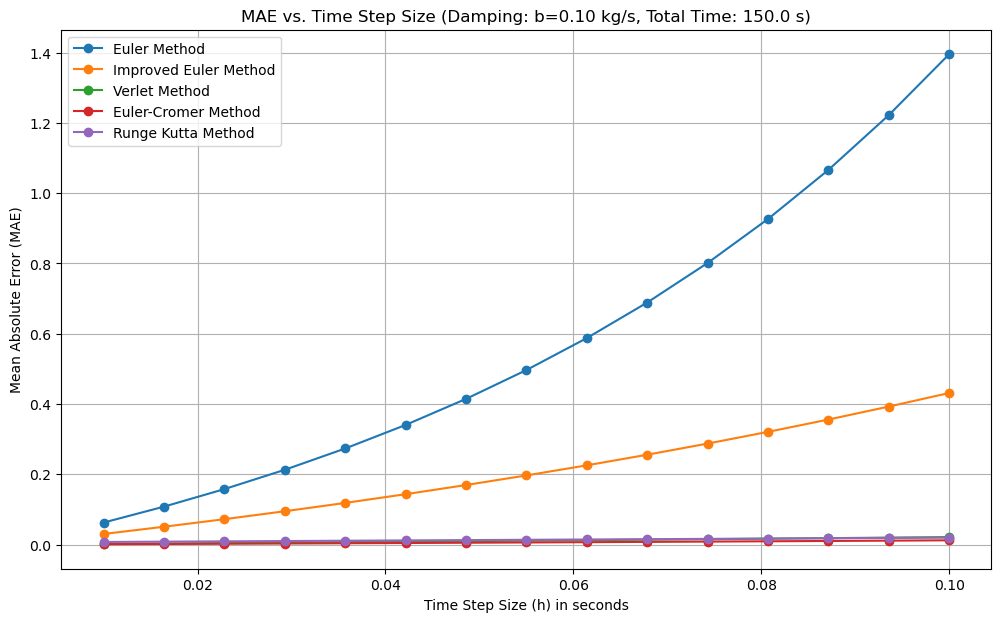

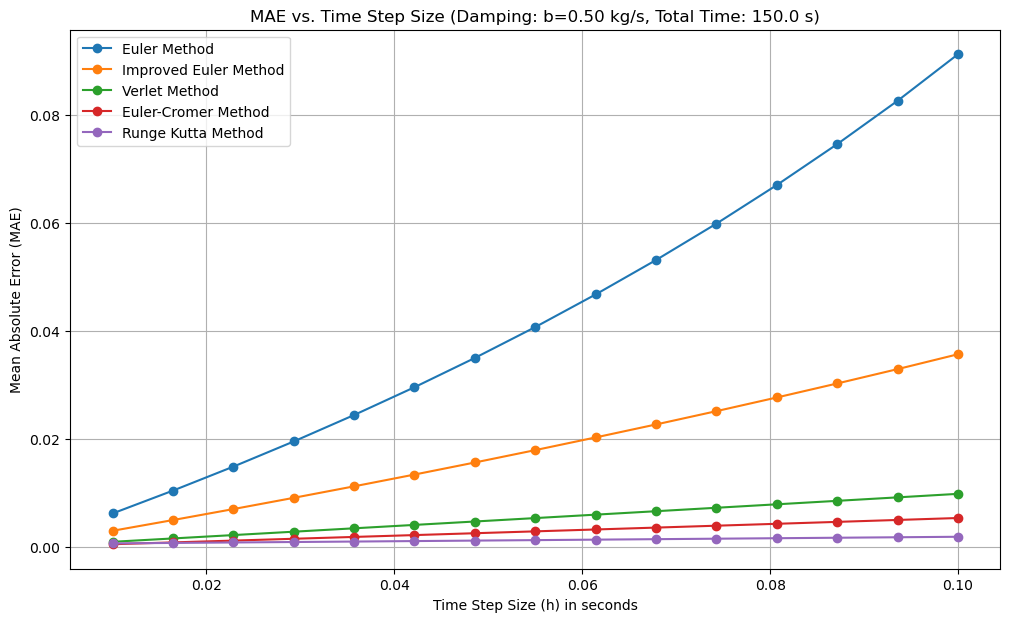

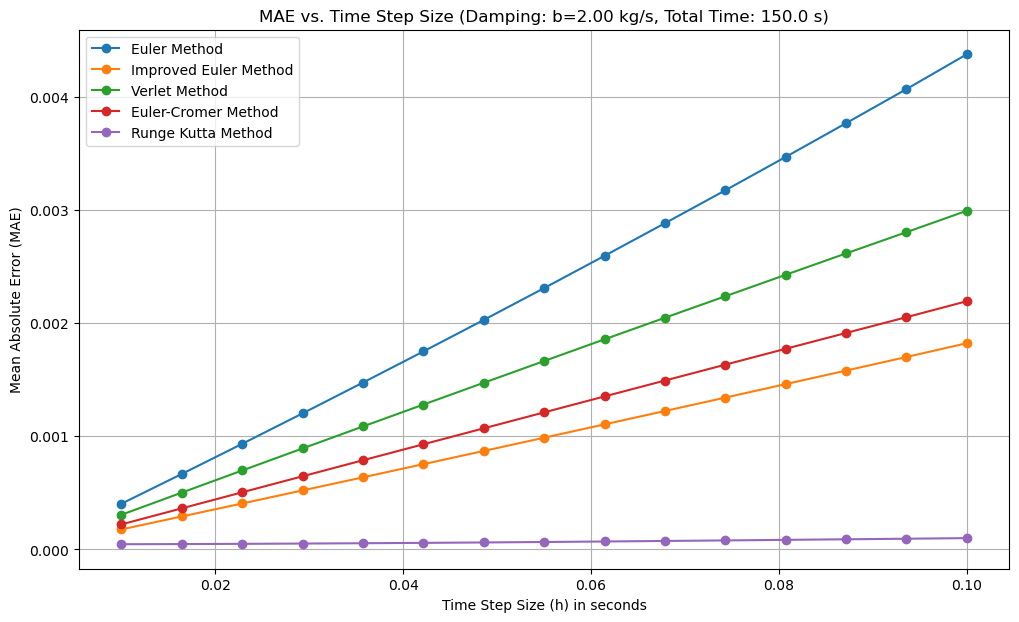

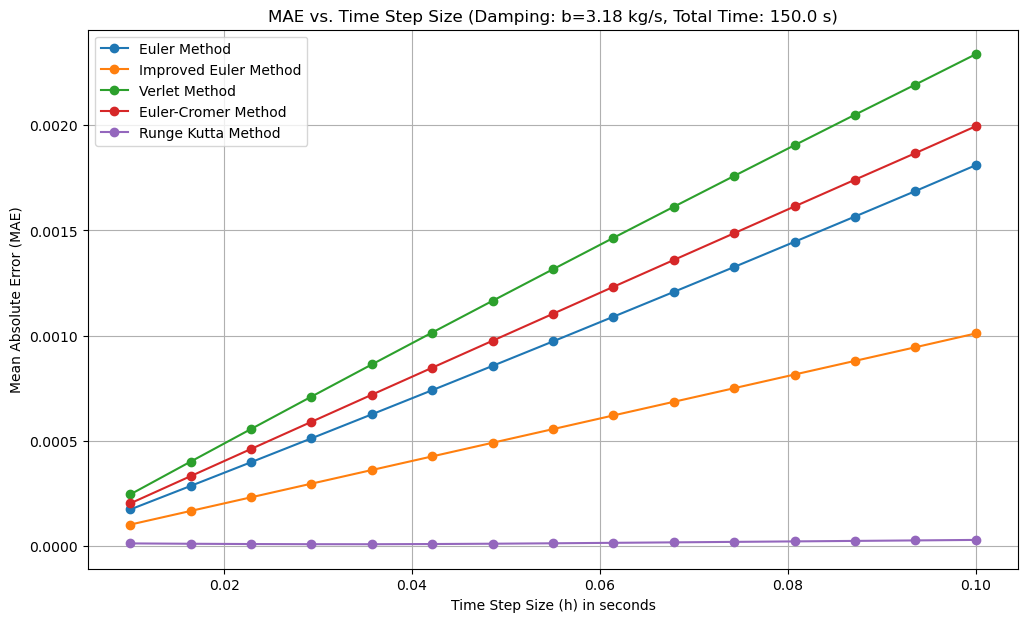

In [31]:
h_values = np.linspace(0.01, 0.1, 15)  # Range of h values

def calculate_mae_all_methods_over_h(h_values, b, T, x0, v0):
    """
    It calculates Mean Absolute Error for all methods for array of time step size h.
    """
    # Method names for proper labelling
    method_names = ['Euler Method', 'Improved Euler Method', 'Verlet Method', 
                    'Euler-Cromer Method', 'Runge Kutta Method']
    mae_values = {name: [] for name in method_names}  # Dictionary to store MAE values for each method
    
    # Iteration through all time steps
    for h in h_values:
        # Run simulation and store positions
        t_range, x_euler, x_improved, x_verlet, x_euler_cromer, x_analytic, x_rk = run_simulation(h, b, T)
        numerical_solutions = [x_euler, x_improved, x_verlet, x_euler_cromer, x_rk]
        
        # Calculate MAE for each method
        for name, solution in zip(method_names, numerical_solutions):
            differences = np.abs(x_analytic - solution)
            mae = np.mean(differences)  # Mean Absolute Error
            mae_values[name].append(mae)
    
    return mae_values

def analyze_and_plot_mae_for_dampings(h_values, dampings, T, x0, v0):
    """
    It runs the plotting function MAE against the step size 
    for all methods for 4 different dampings: 0.1, 0.5, 2.0, 3.18 kg/s.
    """
    # Iteration through all damping coefficients
    for b in dampings:
        # Calculate MAE over h for all methods for the current damping value
        mae_values = calculate_mae_all_methods_over_h(h_values, b, T, x0, v0)

        # Plot the MAE for all methods with a title indicating the damping value
        plot_title = f'MAE vs. Time Step Size (Damping: b={b:.2f} kg/s, Total Time: {T} s)'
        plot_mae_over_h(h_values, mae_values, plot_title)

def plot_mae_over_h(h_values, mae_values, title):
    """
    Plotting function for MAE vs h.
    """
    # Adjusting size of the figure
    plt.figure(figsize=(12, 7))
    
    # Iteration through all names and MAE's
    for name, maes in mae_values.items():
        plt.plot(h_values, maes, label=name, marker='o', linestyle='-')
    
    # Title and labels
    plt.xlabel('Time Step Size (h) in seconds')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

b_array = [0.1, 0.5, 2.0, 3.18]
# Analyze and plot MAE for specified dampings
analyze_and_plot_mae_for_dampings(h_values, b_array, T[1], x0, v0)

### Observation notes 7
We can directly see that Runge-Kutta has smallest error in majority of scenarios except the damping $0.1$ kg/s where Euler-Cromer's is more accurate, however it is not that clear from the graph since the difference is small and the inaccurate scale of the axis due to Euler's shoot off. We can see how Verlet's method worsening as the damping increases and how Euler's and its improved version is getting better for larger damping coefficient.

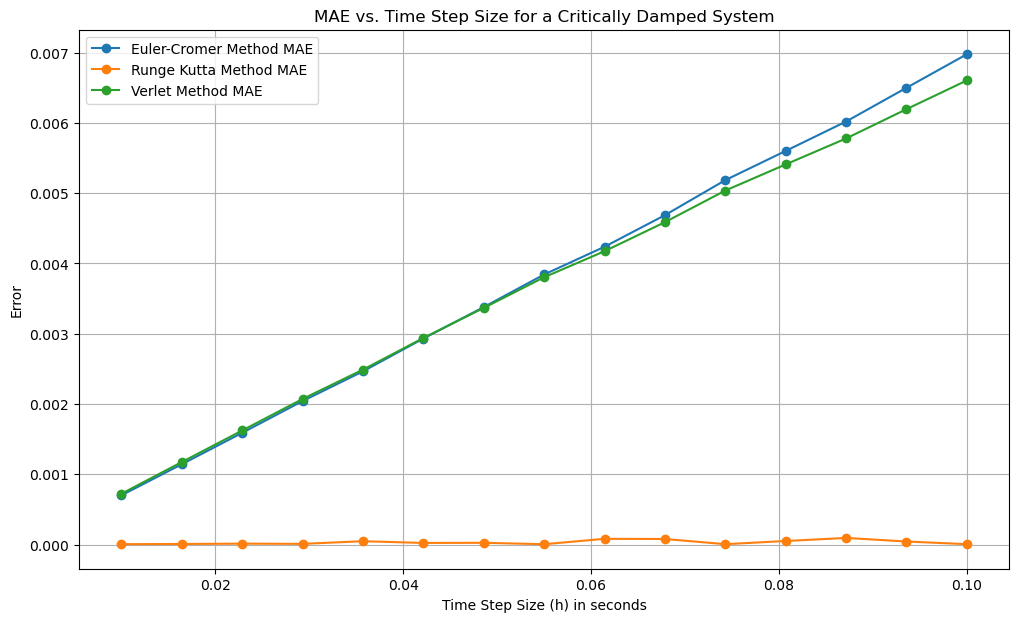

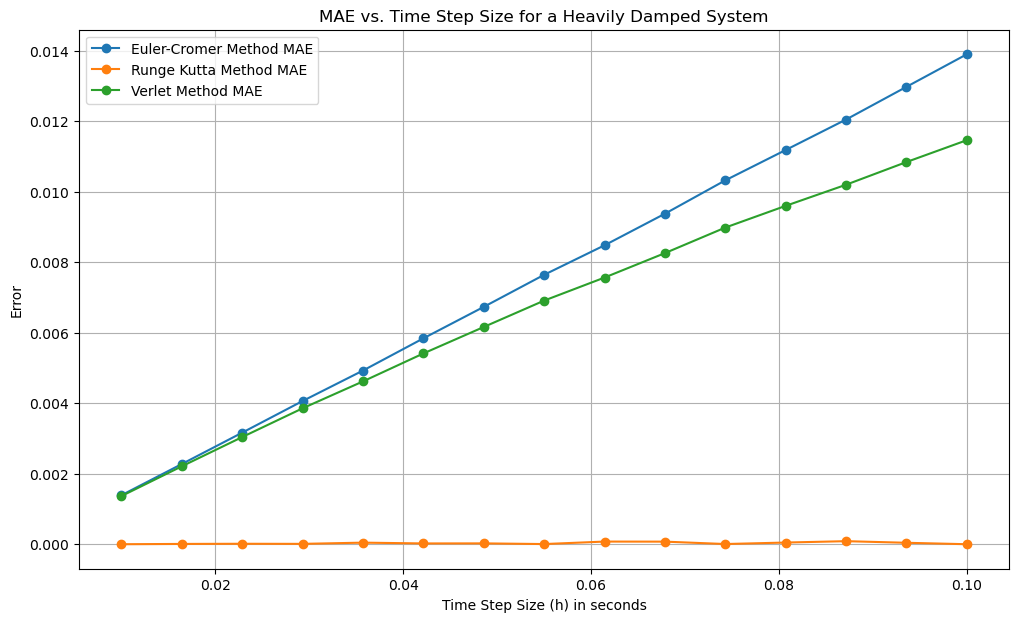

In [32]:
def calculate_errors_for_methods(numerical_solutions, analytical_solution):
    """
    This function collects all errors into an array for further use.
    """
    # Empty array for errors
    errors = {}
    # Iteration through all method names and solutions
    for method_name, solution in numerical_solutions.items():
        errors[method_name] = calculate_errors(analytical_solution, solution)
    return errors

def calculate_mae_for_damping_types(h_values, dampings_info, T):
    """
    It calculates MAE for critical damping and double 
    critical value for best three methods.
    """
    # Iteration through damping coefficients, analytical solution values, and titles
    for b_val, analytical_solution_func, title in dampings_info:
        error_values = {name: {'mae': [], 'mse': [], 'rmse': []} for name in method_names}
        
        # Iteration through all time steps
        for h in h_values:
            # Define number of steps an time range
            nsteps = int(T / h)
            t_range = np.linspace(0, T, nsteps)
            # Define analytical solution
            analytical_solution = analytical_solution_func(x0, v0, t_range, b_val)
            
            # Numerical methods
            numerical_solutions = {
                'Euler-Cromer Method': run_simulation_best(h, b_val, T)[1][:nsteps],
                'Runge Kutta Method': run_simulation_best(h, b_val, T)[2][:nsteps],
                'Verlet Method': run_simulation_best(h, b_val, T)[3][:nsteps],
            }
            # Calculate errors
            errors = calculate_errors_for_methods(numerical_solutions, analytical_solution)
            # Iterate through all error methods
            for name in method_names:
                error_values[name]['mae'].append(errors[name][0])
                error_values[name]['mse'].append(errors[name][1])
                error_values[name]['rmse'].append(errors[name][2])
        # Plot        
        plot_error_over_h(h_values, error_values, title)

def plot_error_over_h(h_values, error_values, title):
    """
    This function plots error MAE vs h for critical conditions.
    """
    # Adjusting size of the figure
    plt.figure(figsize=(12, 7))
    
    # Iterate through 
    for name, error_metrics in error_values.items():
        plt.plot(h_values, error_metrics['mae'], label=f"{name} MAE", marker='o', linestyle='-')
        
    plt.xlabel('Time Step Size (h) in seconds')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the specific dampings and their corresponding analytical solutions
dampings_info = [
    (b_crit, AnalyticCritical, "MAE vs. Time Step Size for a Critically Damped System"),
    (b_double, AnalyticOverdamped, "MAE vs. Time Step Size for a Heavily Damped System")
]

# Call the function
calculate_mae_for_damping_types(h_values, dampings_info, T[0])

### Observation notes 8
In critical situations Runge-Kutta's remains being the best method. We can see that Verlet's and Euler-Cromer's are rather similar with slightly better results for the Verlet's. 

### External Force: Sudden and Sinusoidal
The investigation focuses on a damped mass-spring system subjected to two distinct types of external forces. The first is a transient, impulsive force with a specific duration, while the second is a continuous, sinusoidal force. Computational simulations are conducted utilizing the Runge-Kutta method, which offers a numerical solution to the system's response to these forces over time. The scenarios explore varying magnitudes of the applied force to observe and analyze the system's dynamic behavior.

Particularly in the case of the sudden force, the simulation captures the velocity of the system at the precise moment of force application. This enables an in-depth examination of the interplay between the direction of the system's velocity and the direction of the applied force. The analysis seeks to understand how opposing and aiding directions between force and motion influence the energy transfer within the system, affecting its subsequent oscillatory motion.

#### Sudden Force:
$$F(t) = F_{ext}$$

Equation of motion becomes

$$m\ddot{x}+b\dot{x}+kx=F_{ext}$$

This force is constant and last the duration specified in the code. In here we choose 3 seconds duration for clearer representation of the sudden effect of external force on the system. The magnitudes of force that are under this investigation are $0.5$ and $\pm 2.5$ N.

#### Sinusoidal Force:
$$F(t) = F_{ext}\cos{(\omega t+\phi)}$$

Equation of motion becomes

$$m\ddot{x}+b\dot{x}+kx=F_{ext}\cos{(\omega t+\phi)}$$

This is dynamical force that acts on the system throughout the simulation. Firstly, we set phase to be zero, and angular frequency to be low $0.9$ rad/s. The magnitude of the force remains the same as in sudden force case.

##### Parameters used in this analysis:
$b = 0.5$ kg/s

$h = 0.01$ s

$F_{ext} = 0.5$ and $\pm 2.5$ N

Total time $= 300$ s

$\phi = 0$

$\omega_{ext} = 0.9$ rad/s

Time applied of sudden force $= 20$ s and $38$ s

Duration of sudden force $= 3$ s for all

### Parameters and driving force Runge-Kutta function

In [33]:
# Parameters for the force functions
F_ext = [0.5, 2.5, -2.5]  # Magnitude of the external force (N)
t_apply = 20  # Time to apply the sudden force (s)
t_apply2 = 38  # Time to apply the sudden force (s)
omega_ext = 0.9  # Frequency of the external force (rad/s)
duration = 3 # Sudden force is applied for the certain duration (in seconds)
phi = 0 # Phase

# Number of step and time range
nsteps = int(T[1] / h[2])
t_range = np.linspace(0, T[1], nsteps)

# Runge-Kutta Method with Driving Force
def RungeKuttaDrivingForce(x0, v0, nsteps, hstep, force_func, force_params, b):
    """
    This is Runge-Kutta function with driving force.
    """
    t_span = [0, nsteps * hstep]
    t_eval = np.linspace(t_span[0], t_span[1], nsteps)
    
    def mass_spring_damper_system_with_drive(t, y):
        x, v = y
        dxdt = v
        # The driving force is evaluated at the current time
        driving_force = force_func(t, **force_params)
        dvdt = (driving_force - b * v - k * x) / m
        return [dxdt, dvdt]
    
    y0 = [x0, v0]
    sol = solve_ivp(mass_spring_damper_system_with_drive, t_span, y0, method='RK45', t_eval=t_eval)
    
    return sol.t, sol.y[0], sol.y[1]

### Sudden Force function and its plotting

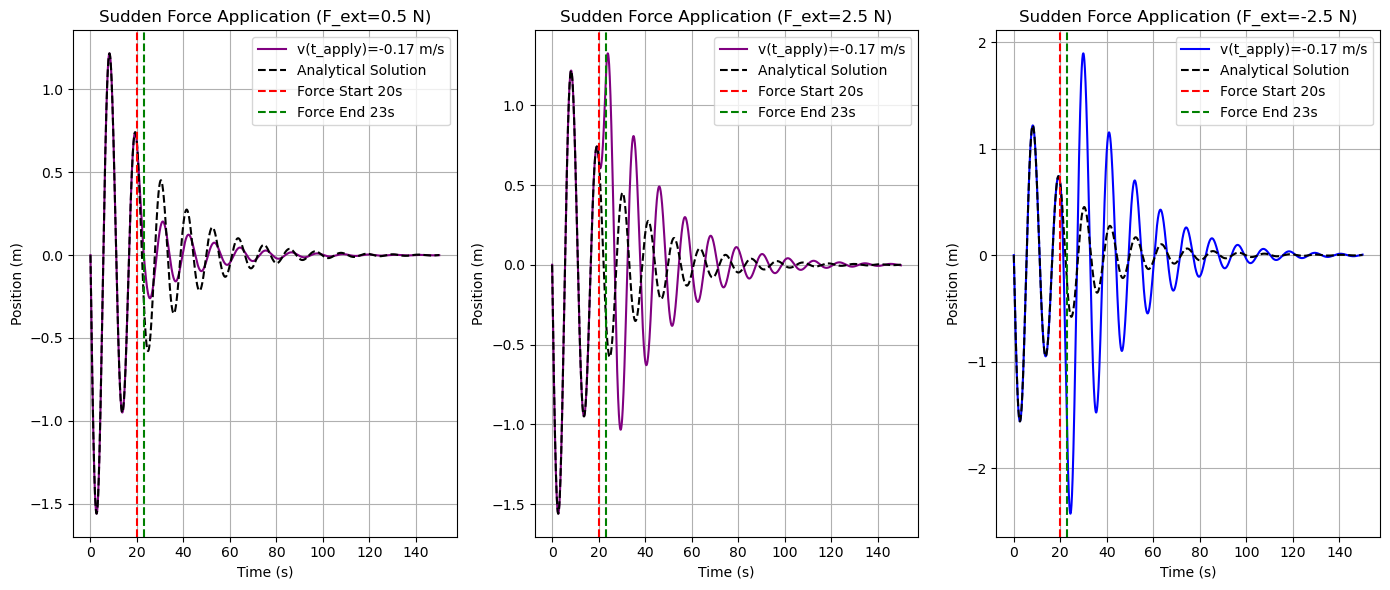

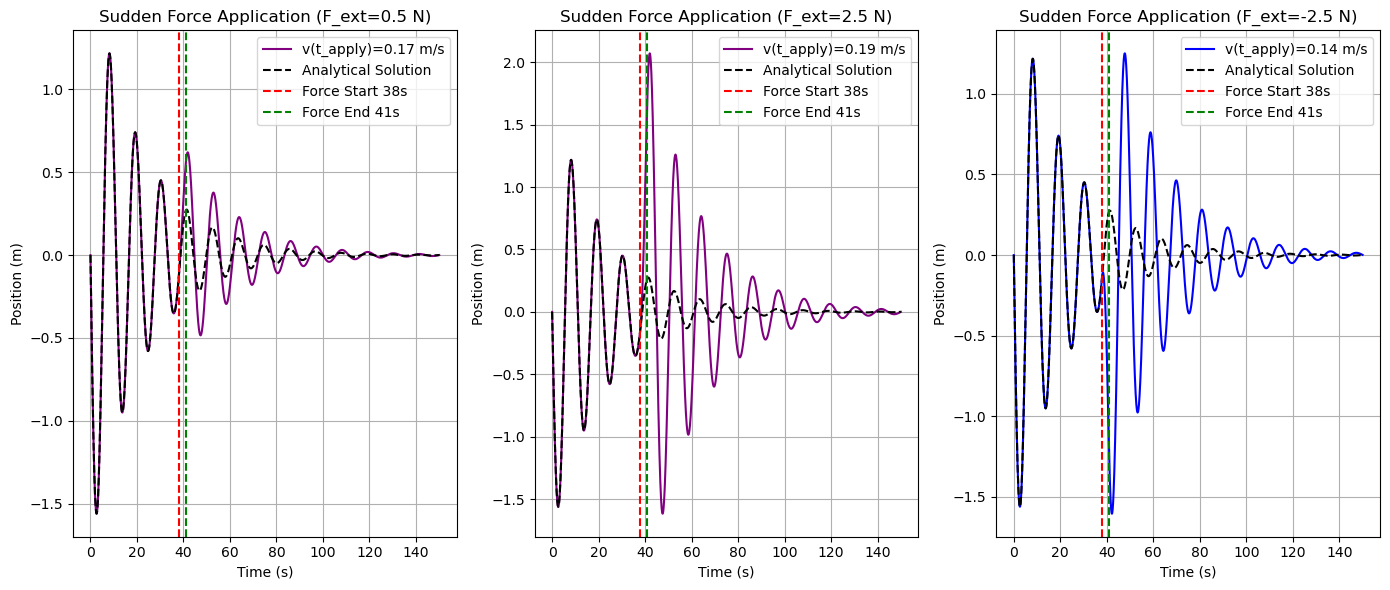

In [34]:
# Sudden force function
def sudden_force(t, F_ext, t_apply, duration):
    """
    Sudden force "push", that can be applied on the system for certain duration.
    """
    if t_apply <= t < t_apply + duration:
        return F_ext
    else:
        return 0

# Function that finds velocity at the time of force application
def get_velocity_at_t_apply(t, v, t_apply):
    """
    This function finds velocity value at the time of the sudden force application.
    """
    # Find the index where the time is closest to t_apply
    idx = (np.abs(t - t_apply)).argmin()
    return v[idx]

# Plotting function
def plot_sudden_force_applications(x0, v0, hstep, nsteps, b, F_ext_range, applied_time):
    """
    Plotting for sudden force application.
    """
    # Adjust figure size
    plt.figure(figsize=(14, 6))
    
    #Iterate through external forces
    for i, F_ext in enumerate(F_ext_range, start=1):
        plt.subplot(1, len(F_ext_range), i)
        force_params = {'F_ext': F_ext, 't_apply': applied_time, 'duration': duration}
        title = f'Sudden Force Application (F_ext={F_ext} N)'
        
        # Call Runge-Kutta Method
        t, x, v = RungeKuttaDrivingForce(x0, v0, nsteps, hstep, sudden_force, force_params, b)
        
        # Search velocity at applied time
        velocity_at_application = get_velocity_at_t_apply(t, v, applied_time)
        
        # Define colours depending on the sign of eternal force: purple is positive, blue is negative
        color = 'purple' if F_ext > 0 else 'blue'
        
        # Plot Runge_Kutta Method 
        plt.plot(t, x, label=f'v(t_apply)={velocity_at_application:.2f} m/s', color=color)
        
        # Analytical solution plot without the external force
        x_analytic = Analytic(x0, v0, t, b).real
        plt.plot(t, x_analytic, 'k--', label='Analytical Solution')
        
        # Vertical lines that shows time of application and its duration
        plt.axvline(x=applied_time, color='red', linestyle='--', label=f'Force Start {applied_time:.3g}s')
        plt.axvline(x=applied_time + duration, color='green', linestyle='--', label=f'Force End {applied_time + duration:.3g}s')
        
        # Title and labels
        plt.title(title)
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


# Call function for plotting
plot_sudden_force_applications(x0, v0, h[2], nsteps, b[1], F_ext, t_apply)
plot_sudden_force_applications(x0, v0, h[2], nsteps, b[1], F_ext, t_apply2)

### Sinusoidal Force and its plotting

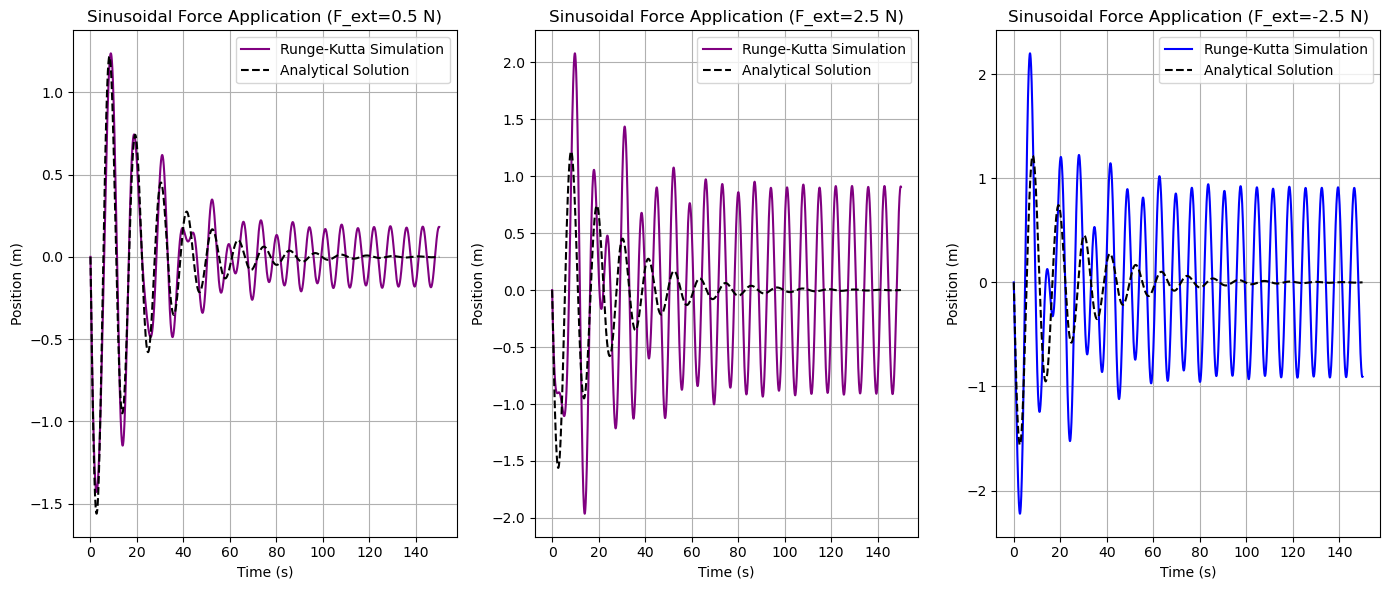

In [35]:
def sinusoidal_force(t, F_ext, omega_ext):
    """
    The sinusoidal force that drives the system throughout.
    """
    return F_ext * np.cos(omega_ext * t + phi)

def plot_sinusoidal_force_applications(x0, v0, hstep, nsteps, b, F_ext_range):
    """
    Plotting for the sinusoidal force. 
    """
    # Adjust the size of the figure
    plt.figure(figsize=(14, 6))
    
    # Iteration through the external force array
    for i, F_ext in enumerate(F_ext_range, start=1):
        plt.subplot(1, len(F_ext_range), i)
        force_params = {'F_ext': F_ext, 'omega_ext': omega_ext}
        title = f'Sinusoidal Force Application (F_ext={F_ext} N)'
        
        # Call Runge-Kutta method
        t, x, _ = RungeKuttaDrivingForce(x0, v0, nsteps, hstep, sinusoidal_force, force_params, b)
        
        # Define colours depending on the sign of eternal force: purple is positive, blue is negative
        color = 'purple' if F_ext > 0 else 'blue'
        
        # Plot Runge_Kutta Method 
        plt.plot(t, x, color=color, label='Runge-Kutta Simulation')
        
        # Analytical solution plot without the external force
        x_analytic = Analytic(x0, v0, t, b).real
        plt.plot(t, x_analytic, 'k--', label='Analytical Solution')
        
        # Title and labels
        plt.title(title)
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
# Call function for plotting
plot_sinusoidal_force_applications(x0, v0, h[2], nsteps, b[1], F_ext)

### Observation notes 9

#### Sudden Force: 
##### Effect of velocity and force directions:
When analyzing the impact of force direction relative to the system's velocity, an external force of magnitude $\pm2.5$ N was applied at two distinct times—20 and 38 seconds—to observe the system's response when the velocity is positive or negative. In the scenarios depicted by the first two graphs, the system has a negative velocity of $-0.17$ m/s at the time of force application.

When a positive force is applied to the system while it has a negative velocity, it acts in opposition to the motion. This opposition temporarily reduces the kinetic energy, decelerating the mass. As a result, the mass changes direction, moving towards the positive axis until the application of force discontinues. The duration of this force is critical; for example, a force applied for 3 seconds against the direction of velocity induces a phase shift of approximately $\pi$ radians, or 180 degrees. Such a phase shift significantly alters the mass-spring system's oscillatory behaviour, illustrating the profound influence of an opposing force.

In contrast, when a negative force coincides with negative velocity, the direction of motion—and consequently, the phase—remains consistent, as the kinetic energy increases, amplifying the system's amplitude. This increase occurs because the force reinforces the direction of velocity, effectively adding energy to the system and enhancing its oscillatory motion.

This principle is mirrored under reversed circumstances, at a different time, demonstrating that the interplay between the direction of applied force and the system's instantaneous velocity governs the energy transfer within the system—constraining or enhancing the amplitude of oscillation accordingly.

#### Sinusoidal Force:
In the first few periods of oscillations, transient effects create an irregular pattern in comparison to the analytical solution without the applied force. After approximately $100$ seconds, in the case of a $0.5$ N external force, the system stabilizes and exhibits steady oscillations that are larger in amplitude than those predicted by the analytical solution. This phenomenon is known as the steady-state response, characterized by oscillations that match the frequency of the applied force, although they may differ in amplitude and phase.

It is noteworthy that applying a negative or positive force does not lead to any significant difference in the system's response.

### Further investigation of sinusoidal force for: low, natural, high frequency
#### Natural Frequency: 
Every oscillating system has one or more natural frequencies, which are the frequencies at which the system tends to vibrate when not subjected to an external force or when it returns to oscillating freely after being disturbed.
We can determine natural frequency of the system using following equation

$$\omega_n = \sqrt{\frac{k}{m}}$$

we also defined low frequency to be $0.1\omega_n$ and high frequency as $6.0\omega_n$. 

This part of experiment aims to investigate phenomenon of resonance. The parameters are used as described in previous part.

#### Resonance:
Resonance occurs in a system when it is exposed to an oscillating external force or a periodic disturbance at a frequency that matches the system's natural frequency of vibration. This condition leads to a significant increase in the amplitude of the system's oscillations.

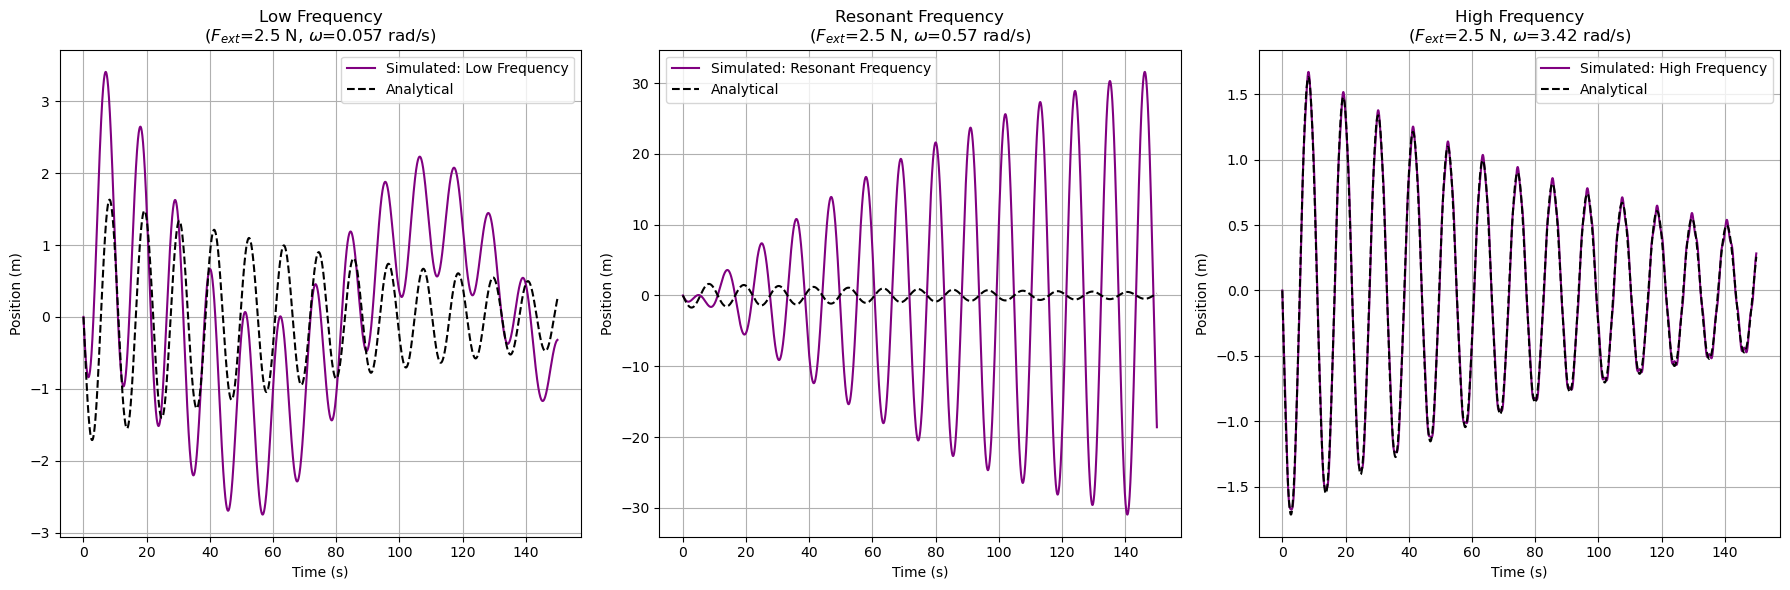

In [36]:
omega_n = np.sqrt(k / m)  # Natural frequency of the system

# Angular frequencies for the external force
omega_list = [
    (0.1 * omega_n, "Low Frequency"),
    (omega_n, "Resonant Frequency"),
    (6.0 * omega_n, "High Frequency")
]

def plot_driving_force_responses(omega_n, omega_list, nsteps, h_step, b,
                                 sinusoidal_force_func, numerical_method,
                                 analytical_solution_func):
    """
    This is plotting function for the driving force responses 
    considering three values of angular frequency: low, resonant, and high.
    """
    # Adjusting size of the figure
    plt.figure(figsize=(18, 6))
    
    # Iteration through values of angular frequency
    for i, (omega_ext, description) in enumerate(omega_list, start=1):
        
        # Run simulation with the specified driving force frequency
        _, x_sinusoidal, _ = numerical_method(x0, v0, nsteps, h_step, 
                                                           sinusoidal_force_func, {'F_ext': F_ext[1], 
                                                                                   'omega_ext': omega_ext}, b)
        
        # Calculate the analytical solution for comparison
        t_range = np.linspace(0, nsteps * h_step, nsteps)
        x_analytical = analytical_solution_func(x0, v0, t_range, b).real

        # Plot simulation results
        plt.subplot(1, len(omega_list), i)
        plt.plot(t_range, x_sinusoidal, label=f'Simulated: {description}', color='purple')
        
        # Plot analytical results
        plt.plot(t_range, x_analytical, label='Analytical', linestyle='--', color='black')
        
        # Title and labels
        plt.title(f'{description}\n($F_{{ext}}$={F_ext[1]:.3g} N, $\\omega$={omega_ext:.3g} rad/s)')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call function for plotting
plot_driving_force_responses(omega_n, omega_list, nsteps, h[2], b[0], 
                             sinusoidal_force, RungeKuttaDrivingForce, Analytic)

### Observation notes 10
The dashed line represents the free oscillation of the system without an external force, showing a consistent, decaying amplitude indicative of natural damped oscillations at the system's own natural frequency.

#### Low frequency:
$\omega = 0.057$ rad/s

There is an apparent initial transient phase where the oscillation amplitude increases and appears irregular compared to the analytical solution. This transient phase is due to the system adapting to the sudden introduction of the external force. It's difficult to assess the phase difference precisely without more detailed information or a clearer view, but based on the plotted data, the solid line seems to be tracking the dashed line closely, indicating a small phase difference between the driving force and the system's response. The amplitude of the system's response is approximately double that of the system without an applied force, which is considerably smaller in contrast to the response at the resonant frequency.

#### Resonant frequency:
$\omega_n = 0.57$ rad/s

At the resonant frequency, the system exhibits a large increase in the amplitude of oscillations, a hallmark of resonance. The energy from the sinusoidal force is being transferred into the system most effectively, causing the amplitude to reach a peak. After initial transients, the amplitude of the oscillations stabilizes due to the balance of energy input from the driving force and the energy dissipated by the damping. The amplitude is about 30-40 times larger than the analytical value for system that oscillates without applied force.

#### High frequency:
$\omega = 3.42$ rad/s

At high driving frequencies, the system's response closely aligns with the analytical solution that represents the undisturbed system. There are no significant phase shifts or changes in amplitude observed, suggesting that the system remains largely unaffected when the driving frequency is six times greater than its natural frequency.

### Further analysis of the resonance

The resonance can be investigated further by plotting maximum amplitude against range of angular frequencies. Aims of this plotting is to observe the peak of the resonant curve under different values of damping. We will use damping coefficients: $0.1$, $0.5$, $2.0$ kg/s.

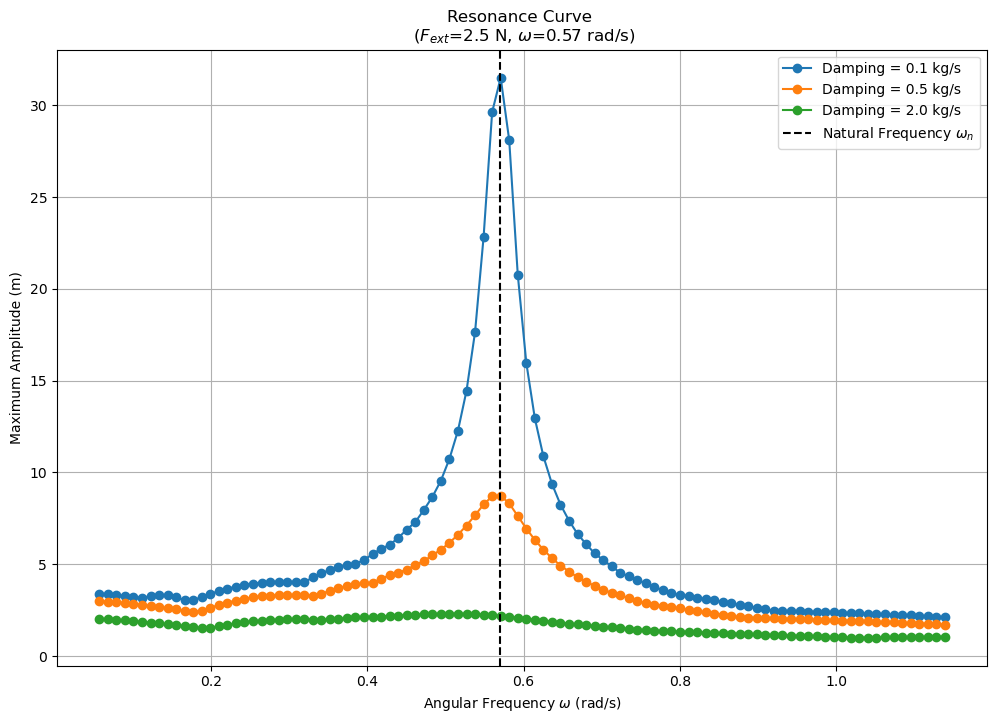

In [37]:
def plot_resonance_curve(omega_n, omega_range, nsteps, h_step, F_ext, b_values):
    """
    This is plotting function of resonance curve. Amplitude vs. angular frequency.
    """
    # Adjusting size of the figure
    plt.figure(figsize=(12, 8))
    
    # Range of omega values
    omega_values = np.linspace(omega_range[0] * omega_n, omega_range[1] * omega_n, 100)
    
    # Iteration through damping coefficients
    for b in b_values:
        # Empty array for amplitude
        max_amplitudes = []
        # Iteration through all omega values
        for omega_ext in omega_values:
            
            # Ensure force_params is correctly structured as a dictionary
            force_params = {'F_ext': F_ext, 'omega_ext': omega_ext}
            
            # Correctly pass force_func and force_params
            _, x_sinusoidal, _ = RungeKuttaDrivingForce(x0, v0, nsteps, h_step, sinusoidal_force, force_params, b)
            
            # Max amplitudes
            max_amplitude = np.max(np.abs(x_sinusoidal))
            max_amplitudes.append(max_amplitude)

        # Plotting
        plt.plot(omega_values, max_amplitudes, label=f'Damping = {b} kg/s', marker='o', linestyle='-', linewidth=1.5)
    
    # Vertical line at natural frequency
    plt.axvline(x=omega_n, color='k', linestyle='--', label='Natural Frequency $\omega_n$')
    
    # Title and labels
    plt.xlabel('Angular Frequency $\omega$ (rad/s)')
    plt.ylabel('Maximum Amplitude (m)')
    plt.title(f'Resonance Curve \n ($F_{{ext}}$={F_ext:.3g} N, $\\omega$={omega_n:.3g} rad/s)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call function for plotting
plot_resonance_curve(omega_n, (0.1, 2), nsteps, h[2], F_ext[1], b)


### Observation notes 11

The dashed vertical line represents the natural frequency of the system ($\omega_n=0.57$ rad/s). It's noticeable that the peak of the curve with the lowest damping aligns closely with this natural frequency, which is typical as undamped systems resonate at their natural frequency.

The curve with the lowest damping (0.1) has the highest peak, signifying a larger resonance amplitude. As the damping increases, the peaks become lower and broader, indicating less energy is stored in the oscillations and more is dissipated.

For higher damping values, the resonant frequency (frequency at which the peak amplitude occurs) appears to shift slightly to the left, i.e., to a lower frequency than the natural frequency. This is a common phenomenon in damped systems - as damping increases, the resonant frequency decreases.

Away from the resonant frequencies, the amplitudes of oscillations are considerably smaller for all damping levels, indicating that the system does not respond strongly to frequencies far from resonance.

Beyond the resonance peak, the amplitude of oscillations decreases sharply for the low damping case, indicating a rapid fall-off in response. The higher damping curves show a more gradual decrease.

### Quality factor

The quality factor $Q$ of a damped harmonic oscillator is a dimensionless parameter that describes the damping of the system. It is defined as the ratio of the peak energy stored in the system to the energy lost per cycle at resonance. For a mass-spring damped system it can be calculated using the formula:

$$Q = \frac{1}{2\zeta} = \frac{m\omega_0}{b}$$

where $\zeta$ is the damping ratio, $m$ is mass, $b$ is the damping coefficient, and $omega_0$ is the natural frequency of the system defined in previous part of the experiment.

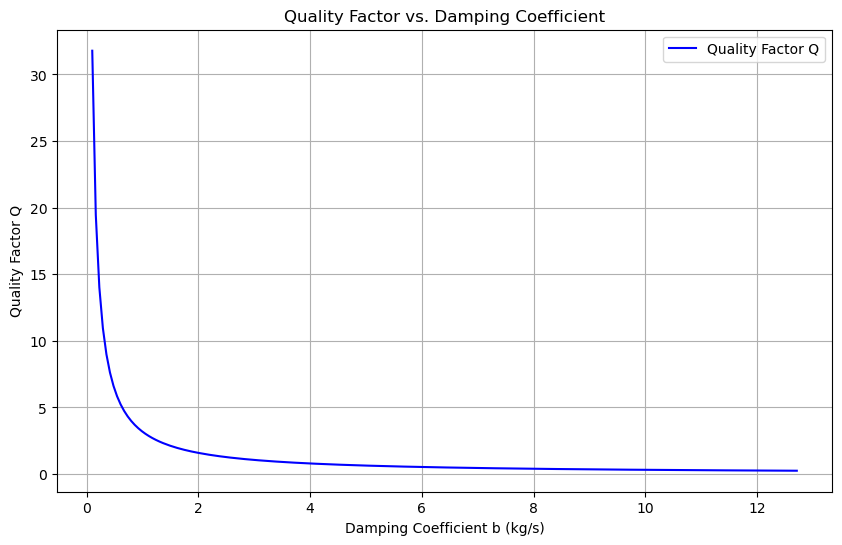

In [38]:
# Determine the array of damping coefficients between 0.1 and double critical value
dampings = np.linspace(0.1, 12.71, 200)

# Quality factor function
def Qfactor(omega_n, m, b):
    """
    This function determines the quality factor of the system.
    """
    # Damping ratios for each damping
    damping_ratios = b / (2 * m * omega_n)
    
    # Quality factors for each damping
    quality_factors = 1 / (2 * damping_ratios)
    
    return quality_factors

# Plot the quality factor as a function of the damping coefficient
def plot_Qfactor(b, q_factor):
    """
    Plotting the Quality factor against the damping coefficients.
    """
    # Adjust size of the figure
    plt.figure(figsize=(10, 6))
    
    # Plot
    plt.plot(b, q_factor, 'b-', label='Quality Factor Q')
    
    # Title and labels
    plt.xlabel('Damping Coefficient b (kg/s)')
    plt.ylabel('Quality Factor Q')
    plt.title('Quality Factor vs. Damping Coefficient')
    
    # Legend and grid
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_Qfactor(dampings, Qfactor(omega_n, m, dampings))

### Observation notes 12

The quality factor, or Q-factor, is inversely proportional to the damping coefficient; as the damping increases, the system's quality factor approaches zero. Conversely, with low damping, the quality factor rises, reaching a peak value of approximately 31.8. The Q-factor provides insight into the resonance peak's "sharpness": high Q-factors correspond to low damping and a sharply defined peak, while low Q-factors are indicative of higher damping, resulting in broader resonance peaks, as was observed in previous experiments.

### Conclusion 
This study critically analyzed the performance of various numerical integration methods: Verlet's, Euler's, Improved Euler's, Euler-Cromer's, and Runge-Kutta applied to a damped mass-spring system. The investigation revealed that the Runge-Kutta method consistently outperformed other methods across a range of scenarios, proving its robustness and accuracy, particularly in systems with lower damping coefficients. The Verlet and Euler-Cromer methods also demonstrated reliable results, although their accuracy diminished as damping increased.

The experiment further explored the system's dynamic response to both sudden and sinusoidal driving forces, revealing the significant impact of the force's direction relative to the system's velocity upon application. Positive forces applied counter to the direction of motion resulted in phase shifts from the analytical solution without driving force and elevated the amplitude. Conversely, negative forces aligned with the motion further amplified the system's amplitude without affecting the phase.

Additionally, the concept of resonance was examined, showing that low damping leads to higher quality factors and sharper resonance peaks. Conversely, increased damping results in a lower quality factor and broader resonance peaks, indicating a more significant energy dissipation. This relationship between damping and the quality factor was clearly illustrated in the experiment, providing valuable insights into the tuning of oscillatory systems for desired resonance characteristics.

In conclusion, the study effectively demonstrated the application and comparative effectiveness of numerical methods in predicting the behavior of damped oscillatory systems and underscored the critical impact of damping on resonance phenomena.